# Purpose:
- Get an example design matrix for Visual Behavior dataset
- Create GLM protocol
- Compare the results with Alex's protocol
- Try Benchmarking using Benjamin et al. 2018 codes

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from allensdk.brain_observatory.behavior.behavior_ophys_experiment import BehaviorOphysExperiment
from brain_observatory_qc.data_access import from_lims
import seaborn as sns
import json
from pprint import pprint
from visual_behavior.data_access import loading
import bz2
import pickle
import xarray as xr
from importlib import reload
import glob

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\visual_behavior_glm')
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_fit_tools as gft
from visual_behavior_glm.glm import GLM

from tqdm.notebook import tqdm

import xgboost as xgb

In [2]:
alex_result_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\ophys_glm\v_24_events_all_L2_optimize_by_session')
alex_result_df = pd.read_pickle(alex_result_dir / 'results.pkl')
alex_run_param = json.load(open(alex_result_dir / 'run_params.json', 'r'))

In [4]:
alex_run_param.keys()

dict_keys(['output_dir', 'figure_dir', 'fig_coding_dir', 'fig_kernels_dir', 'fig_overfitting_dir', 'fig_clustering_dir', 'model_freeze_dir', 'experiment_output_dir', 'job_dir', 'manifest', 'json_path', 'beh_model_dir', 'version', 'creation_time', 'user', 'label', 'experiment_table_path', 'src_file', 'fit_script', 'ElasticNet', 'ElasticNet_nalphas', 'ElasticNet_nL1_ratios', 'L2_optimize_by_cre', 'L2_optimize_by_cell', 'L2_optimize_by_session', 'L2_use_fixed_value', 'L2_fixed_lambda', 'L2_grid_range', 'L2_grid_num', 'L2_grid_type', 'L2_cre_values', 'ophys_experiment_ids', 'job_settings', 'split_on_engagement', 'engagement_preference', 'min_engaged_duration', 'lick_bout_ILI', 'min_time_per_bout', 'min_interval', 'CV_splits', 'CV_subsplits', 'eye_blink_z', 'eye_transient_threshold', 'mean_center_inputs', 'unit_variance_inputs', 'max_run_speed', 'use_events', 'include_invalid_rois', 'interpolate_to_stimulus', 'image_kernel_overlap_tol', 'dropout_threshold', 'version_type', 'kernels', 'dropo

In [24]:

pprint(alex_run_param['kernels'])

{'hits': {'dropout': True,
          'event': 'hit',
          'length': 2.25,
          'num_weights': None,
          'offset': 0,
          'text': 'lick to image change',
          'type': 'discrete'},
 'image0': {'dropout': True,
            'event': 'image0',
            'length': 0.75,
            'num_weights': None,
            'offset': 0,
            'text': 'image presentation',
            'type': 'discrete'},
 'image1': {'dropout': True,
            'event': 'image1',
            'length': 0.75,
            'num_weights': None,
            'offset': 0,
            'text': 'image presentation',
            'type': 'discrete'},
 'image2': {'dropout': True,
            'event': 'image2',
            'length': 0.75,
            'num_weights': None,
            'offset': 0,
            'text': 'image presentation',
            'type': 'discrete'},
 'image3': {'dropout': True,
            'event': 'image3',
            'length': 0.75,
            'num_weights': None,
          

In [7]:
len(alex_result_df)

3012984

In [4]:
alex_result_df.head()

,dropout,absolute_change_from_full,avg_L2_regularization,variance_explained,variance_explained_full,avg_cv_var_test_full_comparison_raw,avg_cv_var_test_raw,avg_cv_var_test_sem,cell_L2_regularization,fraction_change_from_full,...,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id,identifier
0,Full,0.000000,288.892269,0.017993,0.017993,0.017993,0.017993,0.002585,64.189744,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
1,all-images,-0.004065,NaN,0.013928,0.017993,0.017993,0.013928,0.003010,NaN,-0.225934,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
2,all-omissions,-0.000218,NaN,0.017775,0.017993,0.017993,0.017775,0.002572,NaN,-0.012096,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
3,behavioral,0.000756,NaN,0.018749,0.017993,0.017993,0.018749,0.002656,NaN,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
4,image0,-0.000128,NaN,0.017865,0.017993,0.017993,0.017865,0.002586,NaN,-0.007113,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206


In [5]:
list(alex_result_df.columns)

['dropout',
 'absolute_change_from_full',
 'avg_L2_regularization',
 'variance_explained',
 'variance_explained_full',
 'avg_cv_var_test_full_comparison_raw',
 'avg_cv_var_test_raw',
 'avg_cv_var_test_sem',
 'cell_L2_regularization',
 'fraction_change_from_full',
 'shuffle_cells',
 'shuffle_time',
 'cell_specimen_id',
 'adj_fraction_change_from_full',
 'adj_dropout_raw',
 'adj_variance_explained',
 'adj_variance_explained_full',
 'avg_cv_adjvar_test_full_comparison_raw',
 'avg_cv_adjvar_test_raw',
 'cell_roi_id',
 'glm_version',
 'ophys_experiment_id',
 'ophys_session_id',
 'entry_time_utc',
 'equipment_name',
 'full_genotype',
 'mouse_id',
 'reporter_line',
 'driver_line',
 'sex',
 'age_in_days',
 'cre_line',
 'indicator',
 'session_number',
 'prior_exposures_to_session_type',
 'prior_exposures_to_image_set',
 'prior_exposures_to_omissions',
 'behavior_session_id',
 'ophys_container_id',
 'project_code',
 'imaging_depth',
 'targeted_structure',
 'date_of_acquisition',
 'session_type',

In [6]:
len(alex_result_df.ophys_session_id.unique())

544

### Select one experiment to run GLM
- Exc, Novel session

In [8]:
alex_result_df.session_type.unique()

array(['OPHYS_2_images_A_passive', 'OPHYS_4_images_B',
       'OPHYS_5_images_A_passive', 'OPHYS_3_images_A', 'OPHYS_1_images_A',
       'OPHYS_6_images_B', 'OPHYS_5_images_B_passive',
       'OPHYS_2_images_B_passive', 'OPHYS_4_images_A', 'OPHYS_3_images_B',
       'OPHYS_1_images_B', 'OPHYS_6_images_A'], dtype=object)

In [9]:
alex_result_df.cre_line.unique()

array(['Slc17a7-IRES2-Cre', 'Vip-IRES-Cre', 'Sst-IRES-Cre'], dtype=object)

In [13]:
alex_result_df.targeted_structure.unique()

array(['VISp', 'VISl'], dtype=object)

In [14]:
alex_result_df.imaging_depth.unique()

array([375, 175, 152,  75, 300, 150, 225, 275, 359, 371,  79,  81,  73,
       363,  85, 169, 167, 369,  83, 165, 269, 377, 373, 177,  77, 271,
       283, 367, 361, 146, 274, 142, 276, 171, 144,  71, 227, 158, 160,
       279, 219, 217, 140, 365,  51,  87,  69, 263, 215, 267, 259, 211,
       162, 156, 221, 223, 148, 166, 231, 282, 174, 213, 290,  93, 320,
       306, 229, 298, 218, 232, 154, 270, 272, 273, 308, 302, 285, 251,
       145, 278, 179, 312, 383, 381, 228, 230, 284,  61, 292, 233, 289,
        65, 304, 265, 310, 235, 161, 261,  91, 281, 355, 277, 291, 295,
       197, 280,  67,  95, 185, 173, 181, 183, 321, 187, 149, 226, 287,
       315, 220, 222, 294, 322, 147, 316, 296, 286, 132, 348, 350, 379,
       345, 340], dtype=int64)

In [17]:
select_df = alex_result_df[alex_result_df.session_type.str.contains('OPHYS_4_') & alex_result_df.cre_line.str.contains('Slc17a7-IRES2-Cre') & \
                           (alex_result_df.targeted_structure == 'VISp') & (alex_result_df.imaging_depth < 200) & (alex_result_df.imaging_depth > 100)]
len(select_df.ophys_experiment_id.unique())

29

In [19]:
select_df.ophys_experiment_id.unique()

array([ 892799212,  990400775,  879331157,  942043482,  853962951,
       1048044013,  940352367,  885146781,  994278291, 1038360130,
        994082674,  993891844,  817267785, 1076776838,  974358971,
        962471847,  906910614,  963397268,  889775742, 1058275574,
        907694950, 1058813457,  914107592, 1057706462,  903405627,
       1051216600, 1050725735, 1084816952,  808621034], dtype=int64)

In [21]:
len(select_df.query('ophys_experiment_id == 1048044013').cell_roi_id.unique())

113

In [23]:
select_df.dropout.unique()

array(['Full', 'all-images', 'all-omissions', 'behavioral', 'hits',
       'image0', 'image1', 'image2', 'image3', 'image4', 'image5',
       'image6', 'image7', 'intercept', 'licks', 'misses', 'omissions',
       'pupil', 'running', 'single-all-images', 'single-all-omissions',
       'single-behavioral', 'single-hits', 'single-image0',
       'single-image1', 'single-image2', 'single-image3', 'single-image4',
       'single-image5', 'single-image6', 'single-image7', 'single-licks',
       'single-misses', 'single-omissions', 'single-pupil',
       'single-running', 'single-task', 'single-visual', 'task', 'visual'],
      dtype=object)

Text(0, 0.5, 'cumulative probability')

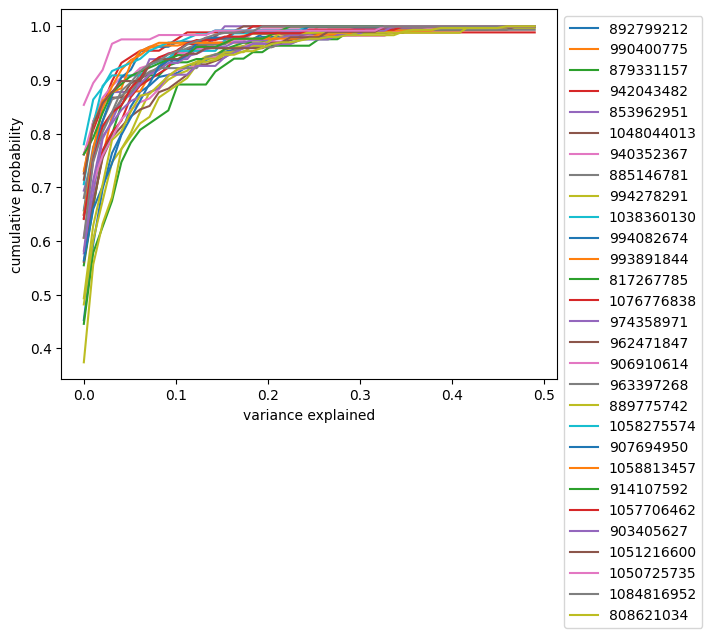

In [28]:
ve_bins = np.linspace(0, 0.5, 50)
fig, ax = plt.subplots()
for ophys_experiment_id in select_df.ophys_experiment_id.unique():
    df = select_df.query('ophys_experiment_id == @ophys_experiment_id and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    ax.plot(ve_bins[:-1], cumhist_vals, label = ophys_experiment_id)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('variance explained')
ax.set_ylabel('cumulative probability')


Text(0, 0.5, 'cumulative probability')

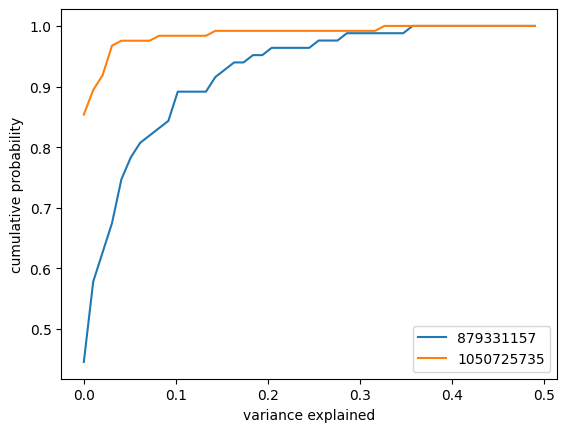

In [36]:
# Get the ones with lowest and highest variance explained
# from cumulative probability at variance explained = 0.1

ve_cutoff = 0.1
ve_bins = np.linspace(0, 0.5, 50)
cutoff_ind = np.where(ve_bins < ve_cutoff)[0][-1]  # the other way of getting the cutoff index (first index larger than the cutoff)
                                                   #gives the second best one, due to an inversion happening exactly at the cutoff
oeids = select_df.ophys_experiment_id.unique()
cumhist_at_cutoff = []
for ophys_experiment_id in oeids:
    df = select_df.query('ophys_experiment_id == @ophys_experiment_id and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    cumhist_at_cutoff.append(cumhist_vals[cutoff_ind])
highest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[0]]
lowest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[-1]]

fig, ax = plt.subplots()
df = select_df.query('ophys_experiment_id == @highest_ve_oeid and dropout == "Full"')
hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
cumhist_vals = np.cumsum(hist_vals)
ax.plot(ve_bins[:-1], cumhist_vals, label = f'{highest_ve_oeid}')
df = select_df.query('ophys_experiment_id == @lowest_ve_oeid and dropout == "Full"')
hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
cumhist_vals = np.cumsum(hist_vals)
ax.plot(ve_bins[:-1], cumhist_vals, label = f'{lowest_ve_oeid}')
ax.legend(loc='lower right')
ax.set_xlabel('variance explained')
ax.set_ylabel('cumulative probability')


In [34]:
len(select_df.query('ophys_experiment_id == @highest_ve_oeid and dropout == "Full"').cell_roi_id.unique())

83

In [32]:
len(select_df.query('ophys_experiment_id == @lowest_ve_oeid and dropout == "Full"').cell_roi_id.unique())

123

### Is there anything related to model performance?
- Rig, etc.

### Let's use 879331157 and 1050725735 for now

In [3]:
oeids = [879331157, 1050725735]

In [44]:
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table()

c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\tables\util\prior_exposure_processing.py:165: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  counts = df.groupby(['mouse_id'])['to'].apply(cumsum)


In [45]:
exp_table.query('ophys_experiment_id in @oeids')[['session_type', 'experience_level' , 'passive', 'image_set', 'equipment_name']]

,session_type,experience_level,passive,image_set,equipment_name
ophys_experiment_id,,,,,
879331157,OPHYS_4_images_B,Novel 1,False,B,CAM2P.3
1050725735,OPHYS_4_images_A,Novel >1,False,A,CAM2P.4


In [8]:
oeid = oeids[0]


In [30]:
kernels_dict = alex_run_param['kernels']

In [33]:
pprint([key for key, _ in kernels_dict.items()])

['intercept',
 'hits',
 'misses',
 'passive_change',
 'omissions',
 'running',
 'pupil',
 'licks',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7']


In [5]:
# dataset = BehaviorOphysExperiment.from_lims(oeid)

c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

In [14]:
dataset = loading.get_ophys_dataset(oeid, get_extended_stimulus_presentations=True,
                                                   get_behavior_movie_timestamps=True)
dataset.extended_stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,is_change,omitted,start_frame,start_time,stop_time,...,flash_after_omitted,flash_after_change,image_name_next_flash,image_index_next_flash,image_name_previous_flash,image_index_previous_flash,lick_on_next_flash,lick_rate_next_flash,lick_on_previous_flash,lick_rate_previous_flash
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0.25021,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,False,False,17986,306.307673,306.557883,...,NaN,NaN,im000,0.0,None,NaN,False,1.000000,NaN,NaN
1,0.25015,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,False,False,18031,307.058343,307.308493,...,False,False,im000,0.0,im000,0.0,True,0.888889,True,1.333333
2,0.25020,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,False,False,18076,307.808903,308.059103,...,False,False,im000,0.0,im000,0.0,False,0.833333,False,1.000000
3,0.25022,18136.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,False,False,18121,308.559503,308.809723,...,False,False,im000,0.0,im000,0.0,False,0.746667,True,0.888889
4,0.25021,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,False,False,18166,309.310123,309.560333,...,False,False,im000,0.0,im000,0.0,False,0.666667,False,0.833333


In [15]:
dataset.extended_stimulus_presentations.columns

Index(['duration', 'end_frame', 'image_index', 'image_name', 'image_set',
       'is_change', 'omitted', 'start_frame', 'start_time', 'stop_time',
       'change', 'pre_change', 'pre_omitted', 'epoch', 'mean_running_speed',
       'mean_pupil_area', 'licks', 'response_latency', 'response_binary',
       'early_lick', 'rewards', 'licked', 'lick_rate', 'rewarded',
       'reward_rate_per_second', 'reward_rate', 'engaged', 'engagement_state',
       'cropped_image_std', 'warped_image_std', 'time_from_last_lick',
       'time_from_last_reward', 'time_from_last_change',
       'time_from_last_omission', 'flash_after_omitted', 'flash_after_change',
       'image_name_next_flash', 'image_index_next_flash',
       'image_name_previous_flash', 'image_index_previous_flash',
       'lick_on_next_flash', 'lick_rate_next_flash', 'lick_on_previous_flash',
       'lick_rate_previous_flash'],
      dtype='object')

In [57]:
for name, value in alex_run_param['kernels'].items():
    print(f'{name}  {value}')

intercept  {'event': 'intercept', 'type': 'continuous', 'length': 0, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'constant value'}
hits  {'event': 'hit', 'type': 'discrete', 'length': 2.25, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'lick to image change'}
misses  {'event': 'miss', 'type': 'discrete', 'length': 2.25, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'no lick to image change'}
passive_change  {'event': 'passive_change', 'type': 'discrete', 'length': 2.25, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'passive session image change'}
omissions  {'event': 'omissions', 'type': 'discrete', 'length': 3, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'image was omitted'}
running  {'event': 'running', 'type': 'continuous', 'length': 2, 'offset': -1, 'num_weights': None, 'dropout': True, 'text': 'normalized running speed'}
pupil  {'event': 'pupil', 'type': 'continuous', 'length': 2, 'offset': -1, 'num_weights': Non

## Try reading a design matrix
- pbz2 files
## It doesn't save the design matrix
- But is saves other fit parameters (such as trace, timepoints, binned_timepoints, interpolation, etc.)
- Using this will be easy to create a design matrix

In [17]:
print(Path(alex_run_param['experiment_output_dir']))

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\ophys_glm\v_24_events_all_L2_optimize_by_session\experiment_model_files


In [21]:
exp_output_dir = Path(alex_run_param['experiment_output_dir'])
compressed_fit_file = exp_output_dir / f'{oeid}.pbz2'
with open(compressed_fit_file, 'rb') as f:
    compressed_fit = f.read()
fit_dict = pickle.loads(bz2.decompress(compressed_fit))

In [58]:
fit_dict['fit_trace_bins']

array([ 306.26998924,  306.30231076,  306.33463228, ..., 3908.40434111,
       3908.43666263, 3908.46898415])

In [61]:
fit_dict['fit_trace_arr']['fit_trace_timestamps'].values

array([ 306.28615   ,  306.31847152,  306.35079304, ..., 3908.38818035,
       3908.42050187, 3908.45282339])

In [48]:
pprint(list(fit_dict.keys()))

['fit_trace_arr',
 'dff_trace_arr',
 'events_trace_arr',
 'fit_trace_timestamps',
 'fit_trace_bins',
 'ophys_frame_rate',
 'stimulus_interpolation',
 'ok_to_fit_preferred_engagement',
 'splits',
 'ridge_splits',
 'L2_grid',
 'avg_L2_regularization',
 'cell_L2_regularization',
 'L2_test_cv',
 'L2_train_cv',
 'L2_at_grid_min',
 'L2_at_grid_max',
 'dropouts',
 'var_shuffle_cells',
 'var_shuffle_cells_threshold',
 'var_shuffle_time',
 'var_shuffle_time_threshold',
 'failed_kernels',
 'failed_dropouts']


In [51]:
fit_dict['stimulus_interpolation']

{'mean_step': 0.03232151762003876,
 'timesteps_per_stimulus': 23,
 'original_fit_arr': <xarray.DataArray (fit_trace_timestamps: 111465, cell_specimen_id: 83)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * fit_trace_timestamps  (fit_trace_timestamps) float64 305.8 ... 3.908e+03
   * cell_specimen_id      (cell_specimen_id) int64 1086516471 ... 1086509073,
 'original_dff_arr': <xarray.DataArray (fit_trace_timestamps: 111465, cell_specimen_id: 83)>
 array([[ 0.02477678, -0.1839284 , -0.04229059, ...,  0.01964524,
         -0.07222927, -0.12464776],
        [ 0.02300248, -0.15209344,  0.02763861, ..., -0.084679  ,
         -0.04036217,  0.04701364],
        [ 0.08345677,  0.01419068, -0.03339947, ...,  0.00465205,
         -0.1330708 , -0.02331483],
        ...,
        [-

In [46]:
fit_dict['ridge_splits']

[array([     0,      1,      2, ..., 108167, 108168, 108169], dtype=int64),
 array([ 2208,  2209,  2210, ..., 83890, 83891, 83892], dtype=int64),
 array([ 15456,  15457,  15458, ..., 110374, 110375, 110376], dtype=int64),
 array([  6624,   6625,   6626, ..., 101546, 101547, 101548], dtype=int64),
 array([ 13248,  13249,  13250, ..., 105960, 105961, 105962], dtype=int64)]

<AxesSubplot:>

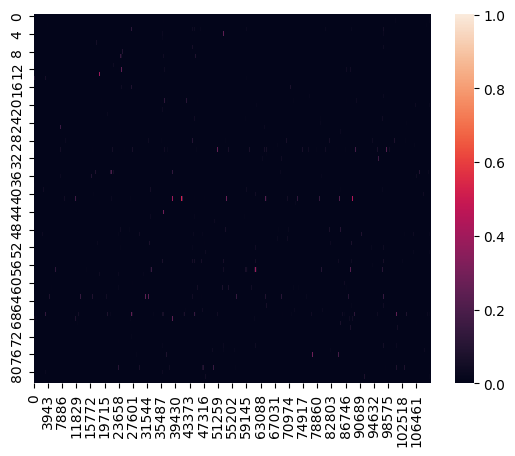

In [38]:
sns.heatmap(fit_dict['fit_trace_arr'].T)

In [39]:
fit_dict['fit_trace_arr'].dims

('fit_trace_timestamps', 'cell_specimen_id')

In [42]:
fit_dict['fit_trace_arr']['cell_specimen_id'].values

array([1086516471, 1086533700, 1086520288, 1086578272, 1086516806,
       1086509375, 1086540983, 1086578816, 1086578908, 1086540615,
       1086529593, 1086578964, 1086510902, 1086511801, 1086517116,
       1086513008, 1086541176, 1086579097, 1086579218, 1086516109,
       1086521665, 1086579811, 1086580033, 1086580079, 1086520733,
       1086509531, 1086523554, 1086527329, 1086524443, 1086580434,
       1086526174, 1086524172, 1086580731, 1086513889, 1086510788,
       1086508541, 1086509183, 1086580991, 1086525678, 1086581181,
       1086519770, 1086513353, 1086511673, 1086521198, 1086511342,
       1086513840, 1086514843, 1086514092, 1086581559, 1086519347,
       1086523862, 1086519252, 1086540818, 1086514645, 1086540340,
       1086540264, 1086582101, 1086519529, 1086582211, 1086582314,
       1086524556, 1086526507, 1086527027, 1086508210, 1086582657,
       1086526849, 1086520162, 1086512268, 1086527898, 1086539650,
       1086582827, 1086535564, 1086513166, 1086583004, 1086512

In [4]:
oeids = [879331157, 1050725735]
oeid = oeids[0]

In [5]:
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus


In [9]:
X = design.get_X()

In [24]:
X.weights.values

array(['intercept_0', 'hits_0', 'hits_1', 'hits_2', 'hits_3', 'hits_4',
       'hits_5', 'hits_6', 'hits_7', 'hits_8', 'hits_9', 'hits_10',
       'hits_11', 'hits_12', 'hits_13', 'hits_14', 'hits_15', 'hits_16',
       'hits_17', 'hits_18', 'hits_19', 'hits_20', 'hits_21', 'hits_22',
       'hits_23', 'hits_24', 'hits_25', 'hits_26', 'hits_27', 'hits_28',
       'hits_29', 'hits_30', 'hits_31', 'hits_32', 'hits_33', 'hits_34',
       'hits_35', 'hits_36', 'hits_37', 'hits_38', 'hits_39', 'hits_40',
       'hits_41', 'hits_42', 'hits_43', 'hits_44', 'hits_45', 'hits_46',
       'hits_47', 'hits_48', 'hits_49', 'hits_50', 'hits_51', 'hits_52',
       'hits_53', 'hits_54', 'hits_55', 'hits_56', 'hits_57', 'hits_58',
       'hits_59', 'hits_60', 'hits_61', 'hits_62', 'hits_63', 'hits_64',
       'hits_65', 'hits_66', 'hits_67', 'hits_68', 'hits_69', 'misses_0',
       'misses_1', 'misses_2', 'misses_3', 'misses_4', 'misses_5',
       'misses_6', 'misses_7', 'misses_8', 'misses_9', 'misses

In [13]:
X.dims

('timestamps', 'weights')

In [29]:
pprint(list(fit.keys()))

['fit_trace_arr',
 'dff_trace_arr',
 'events_trace_arr',
 'fit_trace_timestamps',
 'fit_trace_bins',
 'ophys_frame_rate',
 'stimulus_interpolation',
 'ok_to_fit_preferred_engagement',
 'splits',
 'ridge_splits',
 'L2_grid',
 'avg_L2_regularization',
 'cell_L2_regularization',
 'L2_test_cv',
 'L2_train_cv',
 'L2_at_grid_min',
 'L2_at_grid_max',
 'dropouts',
 'var_shuffle_cells',
 'var_shuffle_cells_threshold',
 'var_shuffle_time',
 'var_shuffle_time_threshold',
 'failed_kernels',
 'failed_dropouts']


In [111]:
fit['var_shuffle_time_threshold']

-0.003245695876971139

In [36]:
fit['dropouts']['Full']['cv_weights'].shape

(604, 83, 5)

In [37]:
np.sum([len(x) for x in fit['ridge_splits']])

110377

In [38]:
[len(x) for x in fit['ridge_splits']]

[22078, 22076, 22072, 22075, 22076]

In [39]:
np.sum([len(x) for x in fit['splits']])

110377

In [40]:
[len(x) for x in fit['splits']]

[22075, 22074, 22076, 22076, 22076]

## Validation set and test set was not divided
- This is a serious problem, leading to overfitting

In [41]:
fit['L2_train_cv'].shape

(83, 40)

In [26]:
alex_result_df.head()

,dropout,absolute_change_from_full,avg_L2_regularization,variance_explained,variance_explained_full,avg_cv_var_test_full_comparison_raw,avg_cv_var_test_raw,avg_cv_var_test_sem,cell_L2_regularization,fraction_change_from_full,...,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id,identifier
0,Full,0.000000,288.892269,0.017993,0.017993,0.017993,0.017993,0.002585,64.189744,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
1,all-images,-0.004065,NaN,0.013928,0.017993,0.017993,0.013928,0.003010,NaN,-0.225934,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
2,all-omissions,-0.000218,NaN,0.017775,0.017993,0.017993,0.017775,0.002572,NaN,-0.012096,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
3,behavioral,0.000756,NaN,0.018749,0.017993,0.017993,0.018749,0.002656,NaN,0.000000,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206
4,image0,-0.000128,NaN,0.017865,0.017993,0.017993,0.017865,0.002586,NaN,-0.007113,...,VisualBehavior,375,VISp,2018-11-13 17:52:17.000000,OPHYS_2_images_A_passive,Familiar,True,A,911741397,778644591_1086491206


## Deal with this problem later
- For now, focus on re-creating the models

# Re-train Alex's models
- Using the exact same data prep
    - Use the same split
- Calculate L2
- Calculate model fit
- Calculate variance explained of each dropout model


In [9]:
oeids = [879331157, 1050725735]

In [10]:
oeid = oeids[0]

In [11]:
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus


In [12]:
X = design.get_X()

In [13]:
fit['ridge_splits']

[array([     0,      1,      2, ..., 108167, 108168, 108169], dtype=int64),
 array([ 2208,  2209,  2210, ..., 83890, 83891, 83892], dtype=int64),
 array([ 15456,  15457,  15458, ..., 110374, 110375, 110376], dtype=int64),
 array([  6624,   6625,   6626, ..., 101546, 101547, 101548], dtype=int64),
 array([ 13248,  13249,  13250, ..., 105960, 105961, 105962], dtype=int64)]

In [14]:
fit['L2_grid']

array([1.00000000e-01, 1.29179487e+01, 2.57358974e+01, 3.85538462e+01,
       5.13717949e+01, 6.41897436e+01, 7.70076923e+01, 8.98256410e+01,
       1.02643590e+02, 1.15461538e+02, 1.28279487e+02, 1.41097436e+02,
       1.53915385e+02, 1.66733333e+02, 1.79551282e+02, 1.92369231e+02,
       2.05187179e+02, 2.18005128e+02, 2.30823077e+02, 2.43641026e+02,
       2.56458974e+02, 2.69276923e+02, 2.82094872e+02, 2.94912821e+02,
       3.07730769e+02, 3.20548718e+02, 3.33366667e+02, 3.46184615e+02,
       3.59002564e+02, 3.71820513e+02, 3.84638462e+02, 3.97456410e+02,
       4.10274359e+02, 4.23092308e+02, 4.35910256e+02, 4.48728205e+02,
       4.61546154e+02, 4.74364103e+02, 4.87182051e+02, 5.00000000e+02])

In [29]:
# Re-create L2 regularization
L2_values = fit['L2_grid']
num_cells = fit['fit_trace_arr'].shape[1]
num_splits = len(fit['ridge_splits'])

cv_ve_L2_test = np.zeros((num_cells,len(L2_values)))
for L2_ind in range(len(L2_values)):
    L2_value = L2_values[L2_ind]

    ve_L2_test = np.zeros((num_cells,num_splits))
    for split_ind in range(num_splits):
        test_split = fit['ridge_splits'][split_ind]
        train_split = np.sort(np.concatenate([fit['ridge_splits'][i] for i in range(num_splits) if i != split_ind]))
        X_test  = X[test_split,:]
        X_train = X[train_split,:]
        fit_trace_train = fit['fit_trace_arr'][train_split,:]
        fit_trace_test  = fit['fit_trace_arr'][test_split,:]
        W = gft.fit_regularized(fit_trace_train, X_train, L2_value)
        Ytest  = X_test.values @ W.values
        var_total = np.var(fit_trace_test, axis=0)
        var_resid = np.var(fit_trace_test - Ytest, axis=0)
        ve_L2_test[:,split_ind] = 1 - var_resid / var_total
        
    cv_ve_L2_test[:,L2_ind] = np.mean(ve_L2_test, axis=1)


### There are edge cases where -Inf is returned
- https://github.com/AllenInstitute/visual_behavior_glm/issues/614

In [64]:
np.unique(np.where(np.isinf(cv_ve_L2_test))[0])

array([18, 78], dtype=int64)

In [65]:
np.var(fit_trace_test.values[:,18])

0.0

In [66]:
np.var(fit_trace_test.values[:,78])

1.912425887335751e-06

In [70]:
np.var(Ytest[:,78])

4.2907588249071623e-10

In [72]:
np.var(Ytest[:,78]) / np.var(fit_trace_test.values[:,78])

0.00022436209702665798

In [79]:
ve_L2_test[78]

array([-0.00844936, -0.00168516,        -inf, -0.00728778,  0.00064298])

In [92]:
for split_ind in range(num_splits):
    test_split = fit['ridge_splits'][split_ind]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    print((fit_trace_test[:,78].values != 0).any())

True
True
False
True
True


In [93]:
for split_ind in range(num_splits):
    test_split = fit['ridge_splits'][split_ind]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    print((fit_trace_test[:,18].values != 0).any())

False
True
True
True
False


In [120]:
lam_each_cell = L2_values[np.argmax(cv_ve_L2_test, axis=1)]
lam_session = np.mean(lam_each_cell)

In [122]:
print(fit['avg_L2_regularization'])
print(lam_session)

273.75548347235093
273.6010503552672


In [102]:
fit['cell_L2_regularization'] == lam_each_cell

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True])

In [108]:
temp_lam_each_cell = np.array([lam if not np.isnan(lam) else L2_values[0] for lam in lam_each_cell])

In [110]:
temp_lam_each_cell[18]

0.1

In [111]:
fit['cell_L2_regularization'][18]

0.1

In [112]:
fit['cell_L2_regularization'] == temp_lam_each_cell

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True])

In [114]:
np.where(fit['cell_L2_regularization'] != lam_each_cell)

(array([40, 62, 81], dtype=int64),)

In [123]:
diff_inds = np.where(fit['cell_L2_regularization'] != lam_each_cell)[0]
for ind in diff_inds:
    print(fit['cell_L2_regularization'][ind])
    print(lam_each_cell[ind])


474.36410256410255
487.18205128205125
500.0
461.54615384615386
448.7282051282051
461.54615384615386


## Lambda values are very slightly different
- I don't know why. Just move on for now, since the difference is very small
## Use session mean lambda as in v24 of Alex's model

In [128]:
alex_run_param['L2_optimize_by_session']

True

In [124]:
num_splits = len(fit['splits'])
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = fit['splits'][split_ind]
    train_split = np.sort(np.concatenate([fit['splits'][i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total


In [131]:
fit['dropouts']['Full']['cv_var_test'].shape

(83, 5)

In [132]:
mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)

(-0.08081956303900295,
 0.3831309783459599,
 -0.08079798736031471,
 0.3831525540246481)

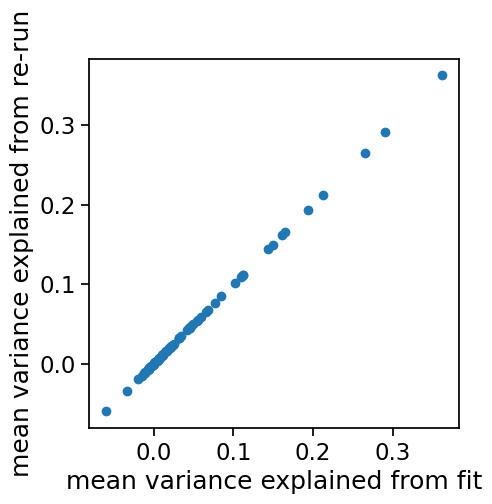

In [134]:
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from re-run')
ax.axis('square')

## Test rerun from the other oeid

In [ ]:
oeid = oeids[1]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)


In [136]:
X = design.get_X()

# Re-create L2 regularization
L2_values = fit['L2_grid']
num_cells = fit['fit_trace_arr'].shape[1]
num_splits = len(fit['ridge_splits'])

cv_ve_L2_test = np.zeros((num_cells,len(L2_values)))
for L2_ind in range(len(L2_values)):
    L2_value = L2_values[L2_ind]

    ve_L2_test = np.zeros((num_cells,num_splits))
    for split_ind in range(num_splits):
        test_split = fit['ridge_splits'][split_ind]
        train_split = np.sort(np.concatenate([fit['ridge_splits'][i] for i in range(num_splits) if i != split_ind]))
        X_test  = X[test_split,:]
        X_train = X[train_split,:]
        fit_trace_train = fit['fit_trace_arr'][train_split,:]
        fit_trace_test  = fit['fit_trace_arr'][test_split,:]
        W = gft.fit_regularized(fit_trace_train, X_train, L2_value)
        Ytest  = X_test.values @ W.values
        var_total = np.var(fit_trace_test, axis=0)
        var_resid = np.var(fit_trace_test - Ytest, axis=0)
        ve_L2_test[:,split_ind] = 1 - var_resid / var_total
        
    cv_ve_L2_test[:,L2_ind] = np.mean(ve_L2_test, axis=1)

In [137]:
np.unique(np.where(np.isinf(cv_ve_L2_test))[0])

array([  2,   4,   9,  10,  11,  15,  16,  30,  32,  34,  36,  41,  43,
        52,  57,  61,  62,  64,  67,  69,  71,  75,  78,  81,  91,  99,
       108, 109, 111, 113, 118], dtype=int64)

In [139]:
len(np.unique(np.where(np.isinf(cv_ve_L2_test))[0]))

31

In [138]:
num_cells

123

In [140]:
oeid

1050725735

In [141]:
lam_each_cell = L2_values[np.argmax(cv_ve_L2_test, axis=1)]
lam_session = np.mean(lam_each_cell)

In [142]:
print(fit['avg_L2_regularization'])
print(lam_session)

280.6359182822597
280.5317073170732


In [144]:
diff_inds = np.where(fit['cell_L2_regularization'] != lam_each_cell)[0]
for ind in diff_inds:
    print(f'For cell_ind {ind}:')
    print(fit['cell_L2_regularization'][ind])
    print(lam_each_cell[ind])

For cell_ind 35:
320.5487179487179
307.7307692307692
For cell_ind 54:
141.09743589743587
128.27948717948718
For cell_ind 88:
102.64358974358973
115.46153846153845


In [145]:
num_splits = len(fit['splits'])
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = fit['splits'][split_ind]
    train_split = np.sort(np.concatenate([fit['splits'][i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total

mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)

Text(0.5, 1.0, 'oeid = 1050725735')

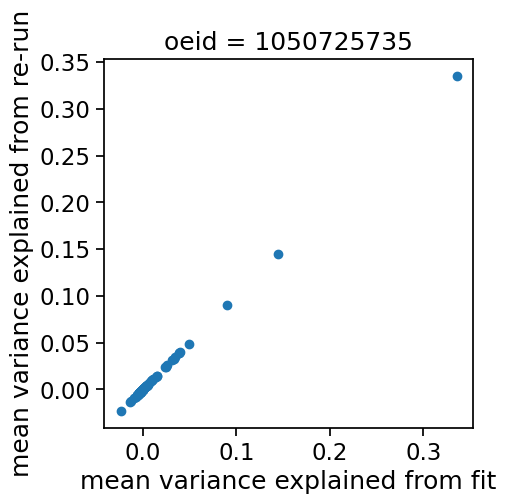

In [146]:
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from re-run')
ax.axis('square')
ax.set_title(f'oeid = {oeid}')

## Confirmed that rerunning works as expected.

# Compare pyglmnet with Alex's model
- Later...

# Run XGBoost using the same design matrix

## Hyper-parameter search

### is continuous split really better than independent frame split?
- Test in GLM (because it is fast)

In [147]:
oeid = oeids[0]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
Checked weight/kernel lengths against timesteps per stimulus


In [148]:
X = design.get_X()


In [155]:
from sklearn.model_selection import KFold
num_samples = X.shape[0]
num_samples // 5

22075

In [157]:
num_samples % 5

2

In [162]:
num_splits = alex_run_param['CV_splits']

In [176]:
div = num_samples // num_splits
rem = num_samples % num_splits

ridge_splits = []
total_inds = np.arange(num_samples)
for i in range(num_splits-1):
    if i < rem:
        temp_split = np.random.choice(total_inds, size=div+1, replace=False)
        ridge_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
    else:
        temp_split = np.random.choice(total_inds, size=div, replace=False)
        ridge_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
ridge_splits.append(total_inds)


In [177]:
cv_splits = []
total_inds = np.arange(num_samples)
for i in range(num_splits-1):
    if i < rem:
        temp_split = np.random.choice(total_inds, size=div+1, replace=False)
        cv_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
    else:
        temp_split = np.random.choice(total_inds, size=div, replace=False)
        cv_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
cv_splits.append(total_inds)

In [180]:
# Re-create L2 regularization
L2_values = fit['L2_grid']
num_cells = fit['fit_trace_arr'].shape[1]
num_splits = len(ridge_splits)

cv_ve_L2_test = np.zeros((num_cells,len(L2_values)))
for L2_ind in range(len(L2_values)):
    L2_value = L2_values[L2_ind]

    ve_L2_test = np.zeros((num_cells,num_splits))
    for split_ind in range(num_splits):
        test_split = ridge_splits[split_ind]
        train_split = np.sort(np.concatenate([ridge_splits[i] for i in range(num_splits) if i != split_ind]))
        X_test  = X[test_split,:]
        X_train = X[train_split,:]
        fit_trace_train = fit['fit_trace_arr'][train_split,:]
        fit_trace_test  = fit['fit_trace_arr'][test_split,:]
        W = gft.fit_regularized(fit_trace_train, X_train, L2_value)
        Ytest  = X_test.values @ W.values
        var_total = np.var(fit_trace_test, axis=0)
        var_resid = np.var(fit_trace_test - Ytest, axis=0)
        ve_L2_test[:,split_ind] = 1 - var_resid / var_total
        
    cv_ve_L2_test[:,L2_ind] = np.mean(ve_L2_test, axis=1)

In [181]:
lam_each_cell = L2_values[np.argmax(cv_ve_L2_test, axis=1)]
lam_session = np.mean(lam_each_cell)

In [183]:
print(fit['avg_L2_regularization'])
print(lam_session)

273.75548347235093
186.19190608588198


Text(0, 0.5, 'L2 regularization from randomized split')

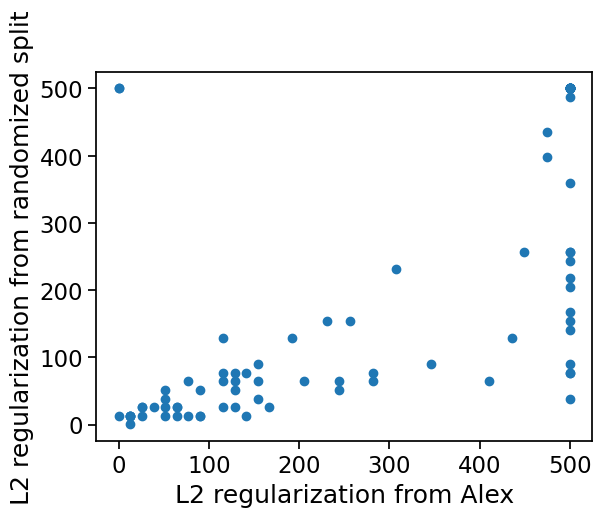

In [182]:
fig, ax = plt.subplots()
ax.scatter(fit['cell_L2_regularization'], lam_each_cell)
ax.set_xlabel('L2 regularization from Alex')
ax.set_ylabel('L2 regularization from randomized split')

In [184]:
# Use the one from random split
num_splits = len(cv_splits)
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total


Text(0.5, 1.0, 'Exp 879331157 using\nrandom split L2 regularization')

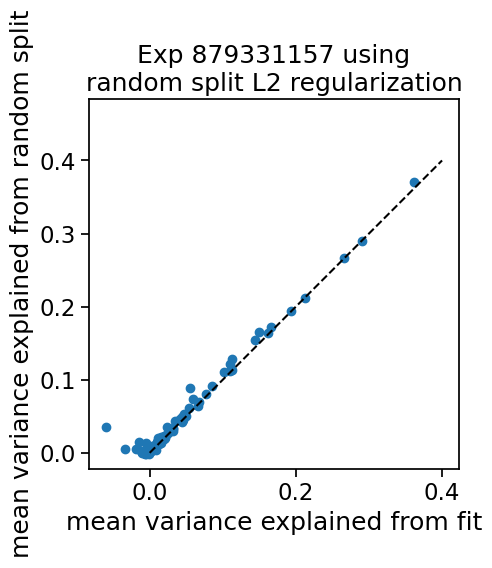

In [202]:
mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from random split')
ax.axis('square')
ax.set_title(f'Exp {oeid} using\nrandom split L2 regularization')

In [188]:
# Use the one from contiguous split
num_splits = len(cv_splits)
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, fit['avg_L2_regularization'])
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total


Text(0.5, 1.0, 'Exp 879331157 using\nAlex split L2 regularization')

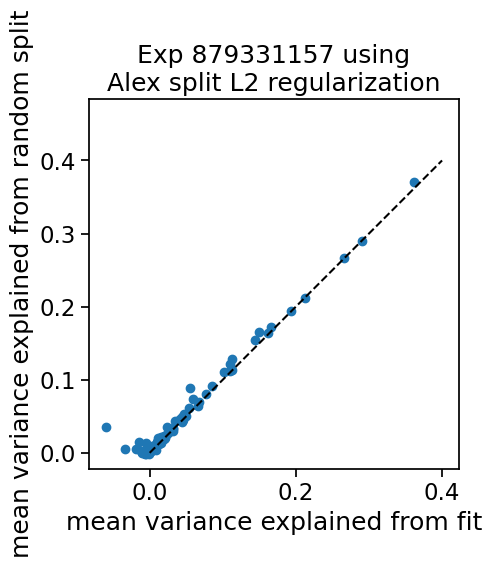

In [203]:
mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from random split')
ax.axis('square')
ax.set_title(f'Exp {oeid} using\nAlex split L2 regularization')

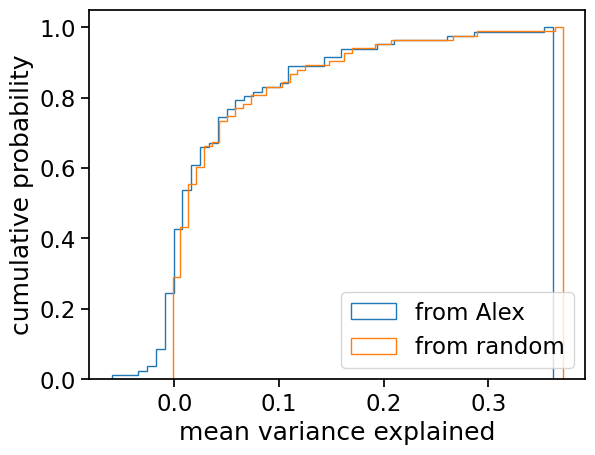

In [204]:
fig, ax = plt.subplots()
ax.hist(mean_ve_test_from_fit[~np.isinf(mean_ve_test_from_fit)], bins=50, cumulative=True, density=True, label='from Alex', histtype='step');
ax.hist(mean_ve_test_from_rerun[~np.isinf(mean_ve_test_from_rerun)], bins=50, cumulative=True, density=True, label='from random', histtype='step');
ax.set_xlabel('mean variance explained')
ax.set_ylabel('cumulative probability')
ax.legend(loc='lower right')

In [206]:
# compare between two lambdas
# fit both from random split
cv_ve_test_random_lambda = np.zeros((num_cells,num_splits))
cv_ve_test_cont_lambda = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]

    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test_random_lambda[:,split_ind] = 1 - var_resid / var_total

    W = gft.fit_regularized(fit_trace_train, X_train, fit['avg_L2_regularization'])
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test_cont_lambda[:,split_ind] = 1 - var_resid / var_total


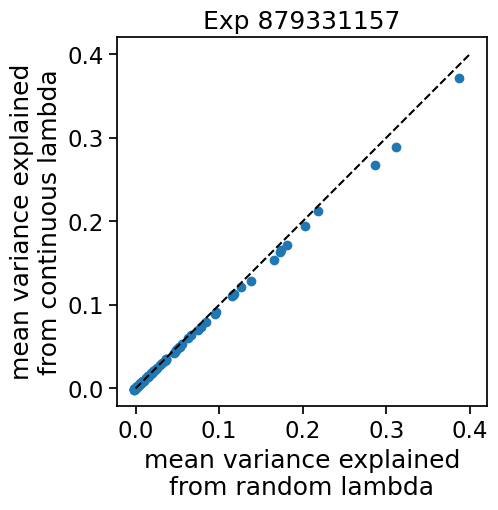

In [214]:
mean_ve_test_from_rand_lam = np.mean(cv_ve_test_random_lambda, axis=1)
mean_ve_test_from_cont_lam = np.mean(cv_ve_test_cont_lambda, axis=1)
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_rand_lam, mean_ve_test_from_cont_lam)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained\nfrom random lambda')
ax.set_ylabel('mean variance explained\nfrom continuous lambda')
ax.axis('square');
ax.set_title(f'Exp {oeid}');


### Test on the other oeid

In [215]:
oeid = oeids[1]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Ind

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
Checked weight/kernel lengths against timesteps per stimulus


In [216]:
X = design.get_X()
num_splits = alex_run_param['CV_splits']

div = num_samples // num_splits
rem = num_samples % num_splits

ridge_splits = []
total_inds = np.arange(num_samples)
for i in range(num_splits-1):
    if i < rem:
        temp_split = np.random.choice(total_inds, size=div+1, replace=False)
        ridge_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
    else:
        temp_split = np.random.choice(total_inds, size=div, replace=False)
        ridge_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
ridge_splits.append(total_inds)

cv_splits = []
total_inds = np.arange(num_samples)
for i in range(num_splits-1):
    if i < rem:
        temp_split = np.random.choice(total_inds, size=div+1, replace=False)
        cv_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
    else:
        temp_split = np.random.choice(total_inds, size=div, replace=False)
        cv_splits.append(np.sort(temp_split))
        total_inds = np.setdiff1d(total_inds, temp_split)
cv_splits.append(total_inds)

In [217]:
# Re-create L2 regularization
L2_values = fit['L2_grid']
num_cells = fit['fit_trace_arr'].shape[1]
num_splits = len(ridge_splits)

cv_ve_L2_test = np.zeros((num_cells,len(L2_values)))
for L2_ind in range(len(L2_values)):
    L2_value = L2_values[L2_ind]

    ve_L2_test = np.zeros((num_cells,num_splits))
    for split_ind in range(num_splits):
        test_split = ridge_splits[split_ind]
        train_split = np.sort(np.concatenate([ridge_splits[i] for i in range(num_splits) if i != split_ind]))
        X_test  = X[test_split,:]
        X_train = X[train_split,:]
        fit_trace_train = fit['fit_trace_arr'][train_split,:]
        fit_trace_test  = fit['fit_trace_arr'][test_split,:]
        W = gft.fit_regularized(fit_trace_train, X_train, L2_value)
        Ytest  = X_test.values @ W.values
        var_total = np.var(fit_trace_test, axis=0)
        var_resid = np.var(fit_trace_test - Ytest, axis=0)
        ve_L2_test[:,split_ind] = 1 - var_resid / var_total
        
    cv_ve_L2_test[:,L2_ind] = np.mean(ve_L2_test, axis=1)

In [218]:
lam_each_cell = L2_values[np.argmax(cv_ve_L2_test, axis=1)]
lam_session = np.mean(lam_each_cell)
print(fit['avg_L2_regularization'])
print(lam_session)

280.6359182822597
388.28584531999167


Text(0, 0.5, 'L2 regularization from randomized split')

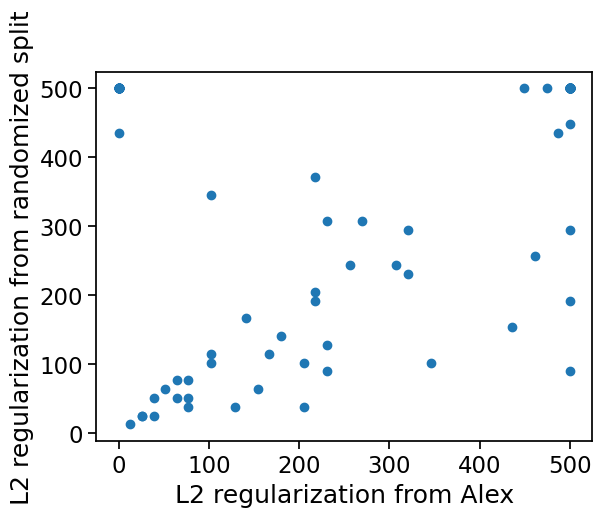

In [219]:
fig, ax = plt.subplots()
ax.scatter(fit['cell_L2_regularization'], lam_each_cell)
ax.set_xlabel('L2 regularization from Alex')
ax.set_ylabel('L2 regularization from randomized split')

In [220]:
# Use the one from random split
num_splits = len(cv_splits)
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total


Text(0.5, 1.0, 'Exp 1050725735 using\nrandom split L2 regularization')

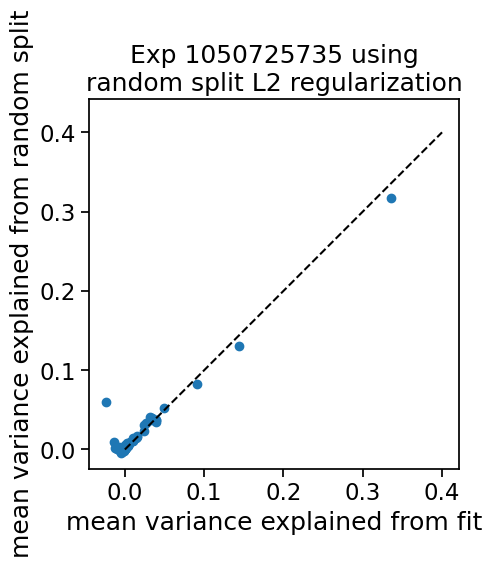

In [221]:
mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from random split')
ax.axis('square')
ax.set_title(f'Exp {oeid} using\nrandom split L2 regularization')

In [222]:
# Use the one from contiguous split
num_splits = len(cv_splits)
cv_ve_test = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]
    W = gft.fit_regularized(fit_trace_train, X_train, fit['avg_L2_regularization'])
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test[:,split_ind] = 1 - var_resid / var_total

Text(0.5, 1.0, 'Exp 1050725735 using\nAlex split L2 regularization')

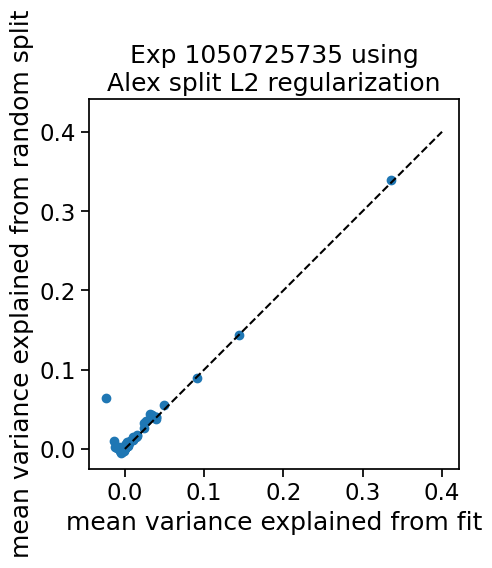

In [223]:
mean_ve_test_from_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
mean_ve_test_from_rerun = np.mean(cv_ve_test, axis=1)
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_fit, mean_ve_test_from_rerun)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained from fit')
ax.set_ylabel('mean variance explained from random split')
ax.axis('square')
ax.set_title(f'Exp {oeid} using\nAlex split L2 regularization')

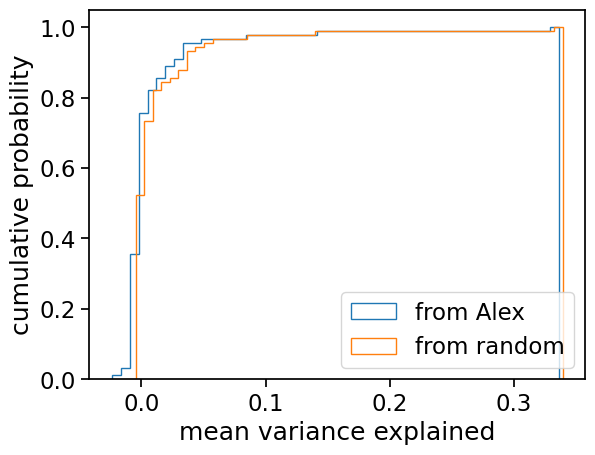

In [227]:
fig, ax = plt.subplots()
non_inf_inds = ~np.isinf(mean_ve_test_from_fit) & ~np.isinf(mean_ve_test_from_rerun)
ax.hist(mean_ve_test_from_fit[non_inf_inds], bins=50, cumulative=True, density=True, label='from Alex', histtype='step');
ax.hist(mean_ve_test_from_rerun[non_inf_inds], bins=50, cumulative=True, density=True, label='from random', histtype='step');
ax.set_xlabel('mean variance explained')
ax.set_ylabel('cumulative probability')
ax.legend(loc='lower right')

In [225]:
# compare between two lambdas
# fit both from random split
cv_ve_test_random_lambda = np.zeros((num_cells,num_splits))
cv_ve_test_cont_lambda = np.zeros((num_cells,num_splits))
for split_ind in range(num_splits):
    test_split = cv_splits[split_ind]
    train_split = np.sort(np.concatenate([cv_splits[i] for i in range(num_splits) if i != split_ind]))
    X_test  = X[test_split,:]
    X_train = X[train_split,:]
    fit_trace_train = fit['fit_trace_arr'][train_split,:]
    fit_trace_test  = fit['fit_trace_arr'][test_split,:]

    W = gft.fit_regularized(fit_trace_train, X_train, lam_session)
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test_random_lambda[:,split_ind] = 1 - var_resid / var_total

    W = gft.fit_regularized(fit_trace_train, X_train, fit['avg_L2_regularization'])
    Ytest  = X_test.values @ W.values
    var_total = np.var(fit_trace_test, axis=0)
    var_resid = np.var(fit_trace_test - Ytest, axis=0)
    cv_ve_test_cont_lambda[:,split_ind] = 1 - var_resid / var_total


In [233]:
np.argsort(mean_ve_test_from_rand_lam)

array([ 30,   4,  81,  91,  43,  15,  41,  67,  32,  36,  99,  10, 111,
        61,   1,  78,   9, 109,  76,  62,  64,  25,  70,  60,   5,  71,
        52,  34,  26,   2,  17, 107,  38,  23,  16, 104,  77,  89,  11,
        42,  20,  69, 113,   0, 120,  29,  40,  57,  27,  79,   7,  39,
       108, 117,  95,   8, 106, 101,  97, 122, 112,  28,  85, 118,  59,
        98,  12,  93, 115, 103,  21,  50,  65,  75,  58,   3,  55,  48,
        68,  13,  54,  44,  47,  94,  53,  56,  51,  63,  35,  19,  88,
        72,  33,  92,  86,  31,  45,  87,  22,  96,  14, 116,  80,  66,
        83,  46, 105,  82, 110, 119,  37,  84, 100, 102,  90,  73, 121,
        24,  49,  74,  18,   6, 114], dtype=int64)

In [234]:
np.argsort(mean_ve_test_from_cont_lam)[1:]

array([ 30,   4,  81,  91,  43,  15,  41,  67,  32,  36,  99,  10, 111,
         1,  61, 109,  78,   9,  62,  76,  64,  25,   5,  60,  70,  71,
        52,  34, 107,  26,   2,  17,  38, 104,  23,  16,  77,  89,  42,
        11,  20,  69, 113,   0, 120,  57,  29,  40,  27, 108,   7,  79,
        39, 117,  95,   8,  97, 101, 106, 112, 122, 118,  98,  59,  85,
        28,  12,  93,  21, 115, 103,  50,  75,  58,  65,   3,  55,  48,
        68,  13,  44,  47,  54,  53,  94,  51,  56,  63,  35,  19,  88,
        72,  86,  33,  92,  31,  45,  87,  22,  96,  14, 116,  80,  66,
        83, 105,  46,  82, 110, 119,  37,  84, 100,  73,  90, 102, 121,
        24,  49,  74,  18,   6, 114], dtype=int64)

In [235]:
inds = np.argsort(mean_ve_test_from_cont_lam)[1:]

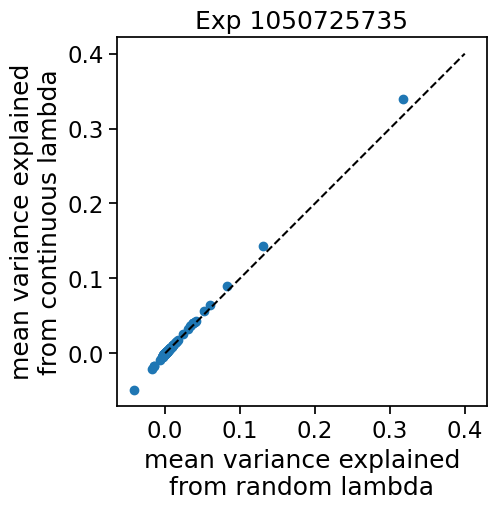

In [236]:
mean_ve_test_from_rand_lam = np.mean(cv_ve_test_random_lambda, axis=1)
mean_ve_test_from_cont_lam = np.mean(cv_ve_test_cont_lambda, axis=1)
inds = np.argsort(mean_ve_test_from_cont_lam)[1:]
fig, ax = plt.subplots()
ax.scatter(mean_ve_test_from_rand_lam[inds], mean_ve_test_from_cont_lam[inds])
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.set_xlabel('mean variance explained\nfrom random lambda')
ax.set_ylabel('mean variance explained\nfrom continuous lambda')
ax.axis('square');
ax.set_title(f'Exp {oeid}');


## Comparable model performance using randomized split
- Use this for hyperparameter search
    - And maybe for all the models?
        - Talk to Alex

## Back to hyperparameter search

In [3]:
oeids = [879331157, 1050725735]

In [4]:
oeid = oeids[0]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)
X = design.get_X()

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus


## First just try with a single hyperparameter

### Choose example cells 
- based on train_variance_explained (i.e., fitting to the full dataset)

(array([55.,  9.,  6.,  4.,  4.,  2.,  0.,  2.,  0.,  1.]),
 array([0.00491395, 0.04294227, 0.08097059, 0.1189989 , 0.15702722,
        0.19505554, 0.23308385, 0.27111217, 0.30914049, 0.3471688 ,
        0.38519712]),
 <BarContainer object of 10 artists>)

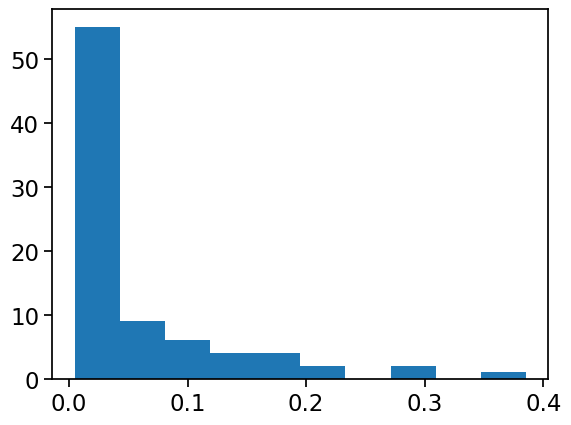

In [13]:
plt.hist(fit['dropouts']['Full']['train_variance_explained'])

In [14]:
model_performance_order = np.argsort(-fit['dropouts']['Full']['train_variance_explained'])

In [15]:
fit['dropouts']['Full']['train_variance_explained'][model_performance_order[0]]

<xarray.DataArray ()>
array(0.38519712)
Coordinates:
    cell_specimen_id  int64 1086519529

In [18]:
cell_ind = model_performance_order[0]

In [19]:
y = fit['fit_trace_arr'][:,cell_ind]

In [ ]:

xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': 0.3,
    'min_child_weight': 1, # 'n_estimators' ignored, num_boost_rounds is used in xgb.train instead (num_rounds)
    'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4,
    'device': 'cuda'} 

In [25]:
dtrain = xgb.DMatrix(X, label=y)
num_round = 200
bst = xgb.train(xgb_params_test, dtrain, num_round)
Ypred = bst.predict(dtrain)

In [26]:
var_total = np.var(y)
var_resid = np.var(y - Ypred)
1 - var_resid / var_total

<xarray.DataArray ()>
array(0.49428823)
Coordinates:
    cell_specimen_id  int64 1086519529

### Vanila XGBoost
- run for all neurons in this experiment

In [15]:

xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': 0.1,
    'min_child_weight': 1, # 'n_estimators' ignored, num_boost_rounds is used in xgb.train instead (num_rounds)
    'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4,
    'device': 'cuda',
    } 

In [16]:
num_round = 200
num_cells = fit['fit_trace_arr'].shape[1]
vanila_xgboost_var_explained = np.zeros(num_cells)
for cell_ind in tqdm(range(num_cells)):
    y = fit['fit_trace_arr'][:,cell_ind]
    dtrain = xgb.DMatrix(X, label=y)
    
    bst = xgb.train(xgb_params_test, dtrain, num_round)
    Ypred = bst.predict(dtrain)
    var_total = np.var(y)
    var_resid = np.var(y - Ypred)
    vanila_xgboost_var_explained[cell_ind] = 1 - var_resid / var_total



  0%|          | 0/83 [00:00<?, ?it/s]

Text(0, 0.5, 'XGBoost')

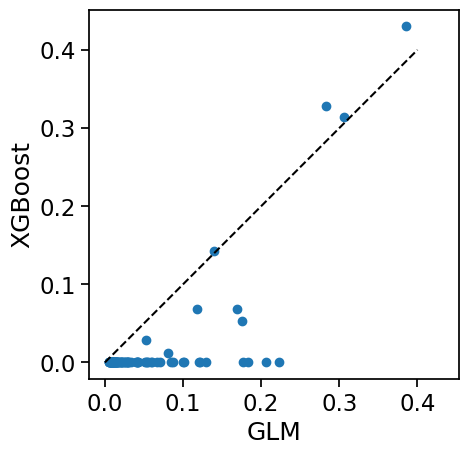

In [17]:
fig, ax = plt.subplots()
ax.scatter(fit['dropouts']['Full']['train_variance_explained'], vanila_xgboost_var_explained)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')

### Vanila parameters do not work well
- Most of the cases variance explained is just 0, possibly meaning that in those cells activities were sparse.
- Check if this is so, and then try different hyperparameters (e.g., scale_pos_weight, etc.)

In [19]:
# Look at the 4 cells nearest to 0.2 in GLM
cell_inds = np.argsort(np.abs(fit['dropouts']['Full']['train_variance_explained'] - 0.2))[:4]

In [23]:
cell_inds.values

array([ 3, 48, 55,  9], dtype=int64)

In [26]:
vanila_xgboost_var_explained[cell_inds.values]

array([0., 0., 0., 0.])

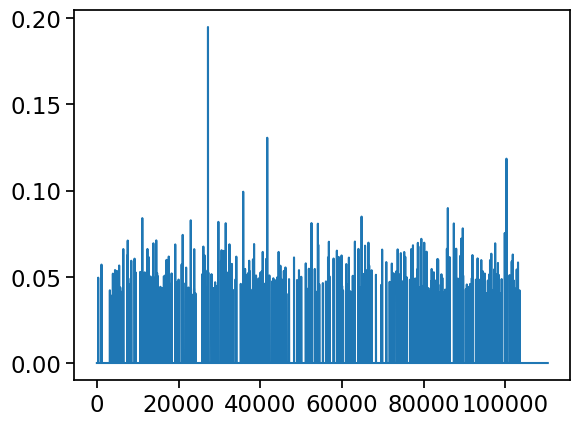

In [31]:
plt.plot(fit['fit_trace_arr'][:,cell_inds.values[0]])

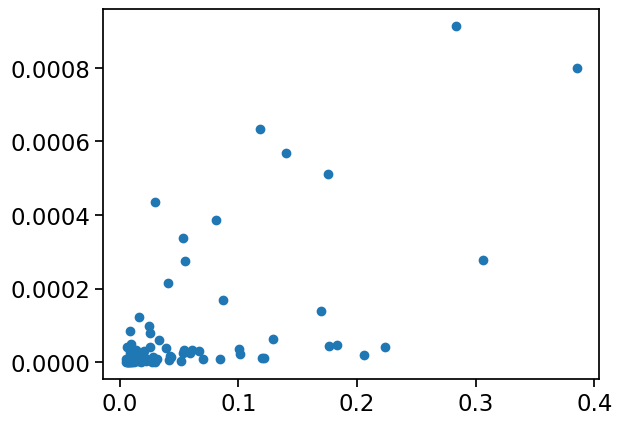

In [33]:
variances = np.var(fit['fit_trace_arr'], axis=0)
plt.scatter(fit['dropouts']['Full']['train_variance_explained'], variances)

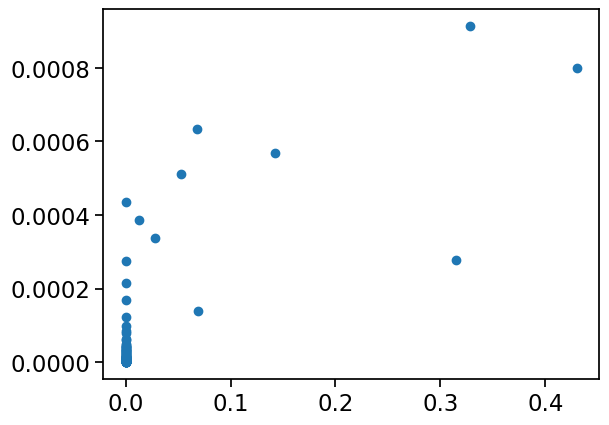

In [34]:
plt.scatter(vanila_xgboost_var_explained, variances)

### This is not always the case...
- But still worth trying

In [43]:
X.shape

(110377, 604)

In [126]:
cell_ind = cell_inds.values[1]
y = fit['fit_trace_arr'][:,cell_ind].values
pos_inds = np.where(y > 0)[0]
zero_inds = np.where(y == 0)[0]
zero_inds_select = np.random.choice(zero_inds, len(pos_inds), replace=False)
train_inds = np.concatenate([pos_inds, zero_inds_select])
# y_train = y[train_inds]
# X_train = X[train_inds,1:]
y_train = y
X_train = X[:,1:]
xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': 0.1,
    'min_child_weight': 2,
    'subsample': 0.6, 'max_depth': 7, 'gamma': 0,
    'device': 'cuda',
    'scale_pos_weight': 50,
    }
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X[:,1:].values)
    
bst = xgb.train(xgb_params_test, dtrain, num_round)
ypred = bst.predict(dtest)
var_total = np.var(y)
var_resid = np.var(y - ypred)
print(1 - var_resid / var_total)

0.9314078360013296


In [112]:
W = fit['dropouts']['Full']['train_weights'].values[:,cell_ind]
yfit = X.values @ W

(11500.0, 11750.0)

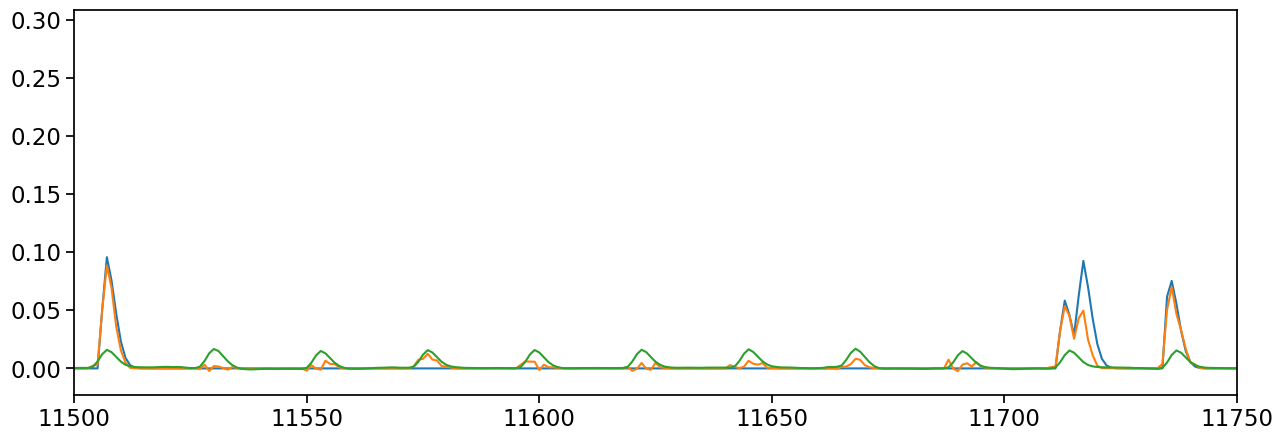

In [122]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y)
ax.plot(ypred)
ax.plot(yfit)
ax.set_xlim(11500, 11750)

In [77]:
1 - np.var(y - yfit) / np.var(y)

0.19598390894885387

In [84]:
len(np.where(y == 0)[0]) / len(np.where(y != 0)[0])

17.399233205534255

In [ ]:
Ytest  = X_test.values @ W.values

In [55]:
Ypred

array([0.00044109, 0.00044109, 0.00044109, ..., 0.00044109, 0.00044109,
       0.00044109], dtype=float32)

### A little tweak in the hyperparameter made it a lot better
- reducing learning rate (but not too much; ~0.1)
- Increasing tree depth (8 or more)
- Reducing gamma (to 0)
    - Possibly overfitting it.
## Try hyperparameter search on CV
- But first, see if this parameter works for all the cells

In [127]:
num_round = 200
num_cells = fit['fit_trace_arr'].shape[1]
xgboost_var_explained = np.zeros(num_cells)
for cell_ind in tqdm(range(num_cells)):
    y = fit['fit_trace_arr'][:,cell_ind]
    dtrain = xgb.DMatrix(X[:,1:], label=y)
    
    bst = xgb.train(xgb_params_test, dtrain, num_round)
    ypred = bst.predict(dtrain)
    var_total = np.var(y)
    var_resid = np.var(y - ypred)
    xgboost_var_explained[cell_ind] = 1 - var_resid / var_total



  0%|          | 0/83 [00:00<?, ?it/s]

Text(0, 0.5, 'XGBoost')

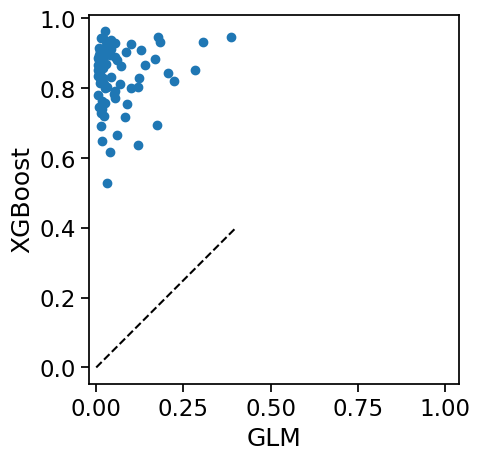

In [128]:
fig, ax = plt.subplots()
ax.scatter(fit['dropouts']['Full']['train_variance_explained'], xgboost_var_explained)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')

## Hyperparameter search on CV

In [134]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
def get_rand_splits(num_samples, num_splits):
    div = num_samples // num_splits
    rem = num_samples % num_splits

    cv_splits = []
    total_inds = np.arange(num_samples)
    for i in range(num_splits-1):
        if i < rem:
            temp_split = np.random.choice(total_inds, size=div+1, replace=False)
            cv_splits.append(np.sort(temp_split))
            total_inds = np.setdiff1d(total_inds, temp_split)
        else:
            temp_split = np.random.choice(total_inds, size=div, replace=False)
            cv_splits.append(np.sort(temp_split))
            total_inds = np.setdiff1d(total_inds, temp_split)
    cv_splits.append(total_inds)
    assert len(np.concatenate(cv_splits)) == num_samples

    return cv_splits

def get_cv_train_test_split(X, y, splits):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for split_ind in range(len(splits)):
        test_split = splits[split_ind]
        train_split = np.sort(np.concatenate([splits[i] for i in range(len(splits)) if i != split_ind]))
        X_test.append(X[test_split,:])
        X_train.append(X[train_split,:])
        y_test.append(y[test_split])
        y_train.append(y[train_split])
    return X_train, X_test, y_train, y_test


def object(space, X_train, y_train, X_test, y_test, num_round=200):
    xgb_params = {'max_depth' : int(space['max_depth']),
                    'gamma' : space['gamma'],
                    'learning_rate' : space['learning_rate'],
                    'min_child_weight' : space['min_child_weight'],
                    'scale_pos_weight' : space['scale_pos_weight'],
                    'subsample' : space['subsample'],
                    'objective' : 'reg:squarederror',
                    'verbosity' : 0,
                    'seed' : 2925,
                    'device' : 'cuda'} 
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    xgb_model = xgb.train(xgb_params, dtrain, num_round=num_round)
    y_pred = xgb_model.predict(dtest)
    loss = np.sum((y_pred - y_test)**2)
    return {'loss': loss, 'status': STATUS_OK,
            'max_depth': space['max_depth'],
            'gamma': space['gamma'],
            'learning_rate': space['learning_rate'],
            'min_child_weight': space['min_child_weight'],
            'scale_pos_weight': space['scale_pos_weight'],
            'subsample': space['subsample'], }

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform ('gamma', 0, 2),
         'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 100),
         'subsample': hp.uniform('subsample', 0.5, 1),         
         }

num_splits = 5
cell_ind = 0
y = fit['fit_trace_arr'][:,cell_ind]
cv_splits = get_rand_splits(len(y), num_splits)
X_train, X_test, y_train, y_test = get_cv_train_test_split(X, y, cv_splits)
best_params = []
loss_values = []
for cv_ind in range(num_splits):
    X_train_cv = X_train[cv_ind]
    y_train_cv = y_train[cv_ind]
    X_test_cv = X_test[cv_ind]
    y_test_cv = y_test[cv_ind]

    trials = Trials()
    
    best_param_cv = fmin(fn=lambda space: object(space, X_train_cv, y_train_cv, X_test_cv, y_test_cv),
                         space=space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    best_params.append(best_param_cv)
    loss_values.append(trials.losses())
    
    

100%|██████████| 200/200 [04:31<00:00,  1.36s/trial, best loss: 0.011889706437361952]


In [150]:
fit['dropouts']['Full']['cv_var_test'].shape

(83, 5)

In [140]:
for key in best_params[0].keys():
    print(key)
    print(np.mean([param[key] for param in best_params]))
    print(np.std([param[key] for param in best_params]))

gamma
1.1256896627431119
0.7180951591684331
learning_rate
0.13103270134679024
0.06732989010564319
max_depth
8.0
5.019960159204453
min_child_weight
4.2
2.4
scale_pos_weight
49.966525371588894
26.738438869535894
subsample
0.792977567415081
0.1841026015224054


In [141]:
mean_best_param = {}
for key in best_params[0].keys():
    mean_best_param[key] = np.mean([param[key] for param in best_params])
mean_best_param

{'gamma': 1.1256896627431119,
 'learning_rate': 0.13103270134679024,
 'max_depth': 8.0,
 'min_child_weight': 4.2,
 'scale_pos_weight': 49.966525371588894,
 'subsample': 0.792977567415081}

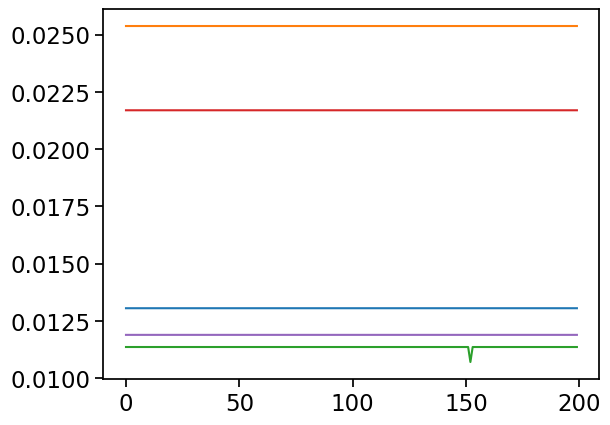

In [143]:
for loss in loss_values:
    plt.plot(loss)

  0%|          | 0/83 [00:00<?, ?it/s]

Text(0, 0.5, 'XGBoost')

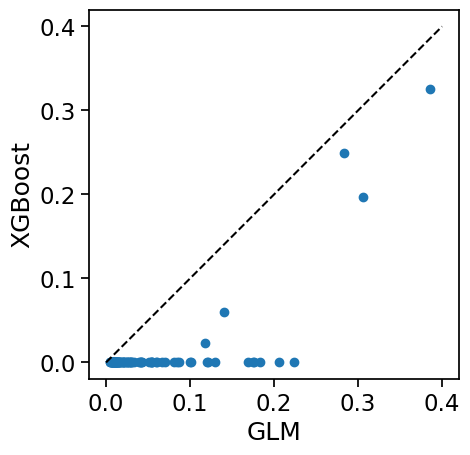

In [145]:
# Try using the mean best params
# First on the full dataset
xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': mean_best_param['learning_rate'],
    'min_child_weight': mean_best_param['min_child_weight'],
    'subsample': mean_best_param['subsample'],
    'max_depth': int(mean_best_param['max_depth']),
    'gamma': mean_best_param['gamma'],
    'device': 'cuda',
    'scale_pos_weight': mean_best_param['scale_pos_weight'],
    }
num_cells = fit['fit_trace_arr'].shape[1]
xgboost_var_explained = np.zeros(num_cells)
for cell_ind in tqdm(range(num_cells)):
    y = fit['fit_trace_arr'][:,cell_ind]
    dtrain = xgb.DMatrix(X, label=y)
    
    bst = xgb.train(xgb_params_test, dtrain, num_round)
    Ypred = bst.predict(dtrain)
    var_total = np.var(y)
    var_resid = np.var(y - Ypred)
    xgboost_var_explained[cell_ind] = 1 - var_resid / var_total

fig, ax = plt.subplots()
ax.scatter(fit['dropouts']['Full']['train_variance_explained'], xgboost_var_explained)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')

### Mean best params do not work
- Maybe because of gamma not being 0?
- with gamma=0, it could all be just overfitting
- Try with gamma=0, and then look at the cross validation results

  0%|          | 0/83 [00:00<?, ?it/s]

Text(0, 0.5, 'XGBoost')

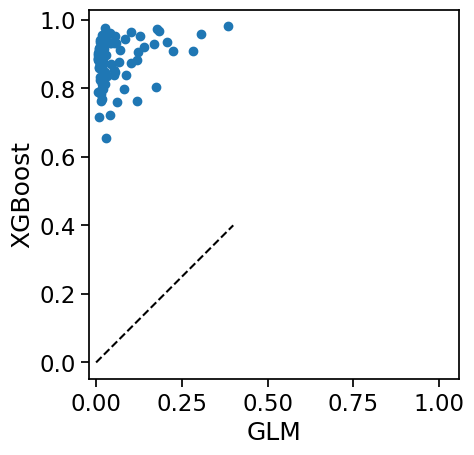

In [147]:
# Try using the mean best params
# First on the full dataset
xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': mean_best_param['learning_rate'],
    'min_child_weight': mean_best_param['min_child_weight'],
    'subsample': mean_best_param['subsample'],
    'max_depth': int(mean_best_param['max_depth']),
    # 'gamma': mean_best_param['gamma'],
    'gamma': 0,
    'device': 'cuda',
    'scale_pos_weight': mean_best_param['scale_pos_weight'],
    }
num_cells = fit['fit_trace_arr'].shape[1]
xgboost_var_explained = np.zeros(num_cells)
for cell_ind in tqdm(range(num_cells)):
    y = fit['fit_trace_arr'][:,cell_ind]
    dtrain = xgb.DMatrix(X, label=y)
    
    bst = xgb.train(xgb_params_test, dtrain, num_round)
    Ypred = bst.predict(dtrain)
    var_total = np.var(y)
    var_resid = np.var(y - Ypred)
    xgboost_var_explained[cell_ind] = 1 - var_resid / var_total

fig, ax = plt.subplots()
ax.scatter(fit['dropouts']['Full']['train_variance_explained'], xgboost_var_explained)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')

  0%|          | 0/83 [00:00<?, ?it/s]

Text(0.5, 1.0, 'test')

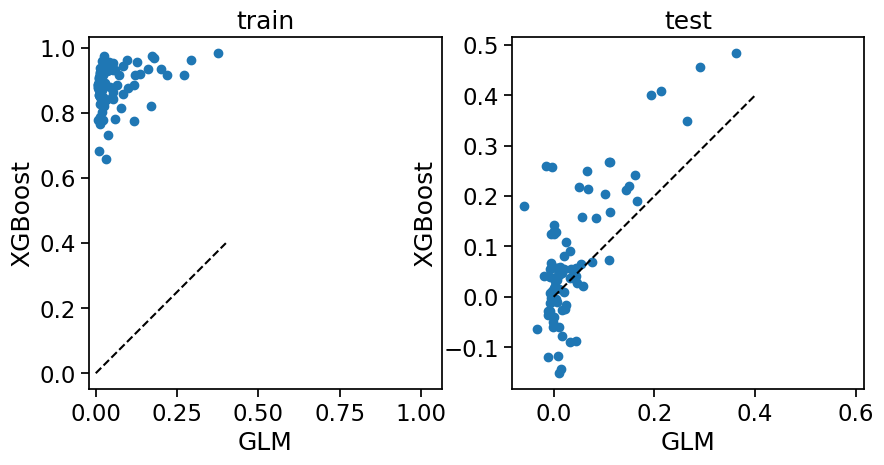

In [157]:
# cross validation
# Try using the mean best params
# First on the full dataset
xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': mean_best_param['learning_rate'],
    'min_child_weight': mean_best_param['min_child_weight'],
    'subsample': mean_best_param['subsample'],
    'max_depth': int(mean_best_param['max_depth']),
    # 'gamma': mean_best_param['gamma'],
    'gamma': 0,
    'device': 'cuda',
    'scale_pos_weight': mean_best_param['scale_pos_weight'],
    }
num_cells = fit['fit_trace_arr'].shape[1]
num_splits = 5
xgboost_var_explained_test = np.zeros((num_cells, num_splits))
xgboost_var_explained_train = np.zeros((num_cells, num_splits))
cv_splits = get_rand_splits(X.shape[0], num_splits)

for cell_ind in tqdm(range(num_cells)):
    y = fit['fit_trace_arr'][:,cell_ind]
    X_train, X_test, y_train, y_test = get_cv_train_test_split(X, y, cv_splits)
    for split_ind in range(num_splits):
        y_train_cv = y_train[split_ind]
        y_test_cv = y_test[split_ind]
        X_train_cv = X_train[split_ind]
        X_test_cv = X_test[split_ind]
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtest = xgb.DMatrix(X_test_cv)
        bst = xgb.train(xgb_params_test, dtrain, num_round)

        ypred = bst.predict(dtrain)
        var_total = np.var(y_train_cv)
        var_resid = np.var(y_train_cv - ypred)
        xgboost_var_explained_train[cell_ind, split_ind] = 1 - var_resid / var_total

        ypred = bst.predict(dtest)
        var_total = np.var(y_test_cv)
        var_resid = np.var(y_test_cv - ypred)
        xgboost_var_explained_test[cell_ind, split_ind] = 1 - var_resid / var_total

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              np.mean(xgboost_var_explained_train, axis=1))
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[0].set_title('train')

ax[1].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
           np.mean(xgboost_var_explained_test, axis=1))
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('GLM')
ax[1].set_ylabel('XGBoost')
ax[1].set_title('test')

## Some reasonable improvement in fitting
- But also a lot of overfitting observed

In [167]:
def object(space, X_train, y_train, X_test, y_test, num_round=200):
        xgb_params = {'max_depth' : int(space['max_depth']),
                        'gamma' : space['gamma'],
                        'learning_rate' : space['learning_rate'],
                        'min_child_weight' : space['min_child_weight'],
                        'scale_pos_weight' : space['scale_pos_weight'],
                        'subsample' : space['subsample'],
                        'objective' : 'reg:squarederror',
                        'verbosity' : 0,
                        'seed' : 2925,
                        'device' : 'cuda'} 
        if 'num_round' in space.keys():
            num_round = int(space['num_round'])
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test)
        xgb_model = xgb.train(xgb_params, dtrain, num_round)
        y_pred = xgb_model.predict(dtest)
        loss = np.sqrt(np.sum((y_pred - y_test)**2))
        return {'loss': loss, 'status': STATUS_OK,
                'max_depth': space['max_depth'],
                'gamma': space['gamma'],
                'learning_rate': space['learning_rate'],
                'min_child_weight': space['min_child_weight'],
                'scale_pos_weight': space['scale_pos_weight'],
                'subsample': space['subsample'], 
                'num_round': num_round,}

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.loguniform ('gamma', -10, -1),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 100),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'num_round': hp.quniform('num_round', 50, 200, 1),
         }

num_splits = 5
cell_ind = 3
y = fit['fit_trace_arr'][:,cell_ind]
cv_splits = get_rand_splits(len(y), num_splits)
X_train, X_test, y_train, y_test = get_cv_train_test_split(X, y, cv_splits)
best_params = []
loss_values = []
for cv_ind in range(num_splits):
    X_train_cv = X_train[cv_ind]
    y_train_cv = y_train[cv_ind]
    X_test_cv = X_test[cv_ind]
    y_test_cv = y_test[cv_ind]

    trials = Trials()

    initial_loss = np.sqrt(np.sum(y_test_cv ** 2))
    print(f'Initial loss: {initial_loss}')
    
    best_param_cv = fmin(fn=lambda space: object(space, X_train_cv, y_train_cv, X_test_cv, y_test_cv),
                         space=space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    best_params.append(best_param_cv)
    loss_values.append(trials.losses())

Initial loss: <xarray.DataArray ()>
array(0.67419434)
Coordinates:
    cell_specimen_id  int64 1086578272
100%|██████████| 50/50 [01:59<00:00,  2.39s/trial, best loss: 0.4996225840461952]
Initial loss: <xarray.DataArray ()>
array(0.63640737)
Coordinates:
    cell_specimen_id  int64 1086578272
100%|██████████| 50/50 [02:02<00:00,  2.46s/trial, best loss: 0.4743914524111558] 
Initial loss: <xarray.DataArray ()>
array(0.60152789)
Coordinates:
    cell_specimen_id  int64 1086578272
100%|██████████| 50/50 [02:00<00:00,  2.40s/trial, best loss: 0.45039903052911934]
Initial loss: <xarray.DataArray ()>
array(0.66815843)
Coordinates:
    cell_specimen_id  int64 1086578272
100%|██████████| 50/50 [02:05<00:00,  2.52s/trial, best loss: 0.4930201147326341] 
Initial loss: <xarray.DataArray ()>
array(0.66698091)
Coordinates:
    cell_specimen_id  int64 1086578272
100%|██████████| 50/50 [02:26<00:00,  2.93s/trial, best loss: 0.5200365639154845]


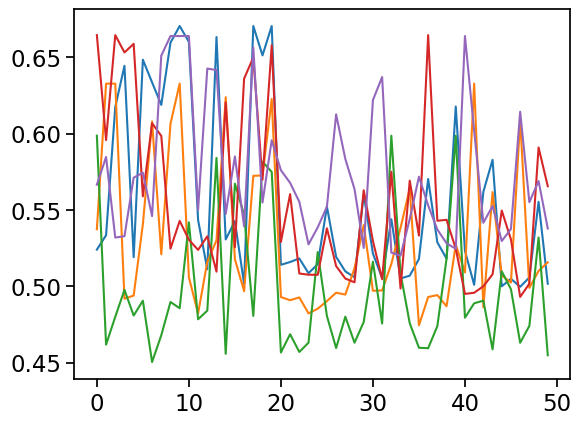

In [169]:
for i in range(len(loss_values)):
    plt.plot(loss_values[i])

In [166]:
cell_ind = 3
np.mean(fit['dropouts']['Full']['cv_var_test'][cell_ind])

0.1934958711387793

In [170]:
mean_best_param = {}
for key in best_params[0].keys():
    mean_best_param[key] = np.mean([param[key] for param in best_params])
mean_best_param

{'gamma': 0.00016559565753713538,
 'learning_rate': 0.06740906552064806,
 'max_depth': 15.2,
 'min_child_weight': 4.4,
 'num_round': 127.2,
 'scale_pos_weight': 59.36697439070947,
 'subsample': 0.7883770309185092}

In [174]:
len(np.where(y==0)[0]) / (len(y) - len(np.where(y==0)[0]))

17.399233205534255

In [176]:
xgboost_var_explained_train_sample = np.zeros(num_splits)
xgboost_var_explained_test_sample = np.zeros(num_splits)
X_train, X_test, y_train, y_test = get_cv_train_test_split(X, y, cv_splits)
sample_best_param = {}
for key in mean_best_param.keys():
    if key == 'num_round':
        num_round = int(np.round(mean_best_param[key]))
    elif key == 'max_depth':
        sample_best_param[key] = int(np.round(mean_best_param[key]))
    else:
        sample_best_param[key] = mean_best_param[key]
    
        
for split_ind in range(num_splits):
    y_train_cv = y_train[split_ind]
    y_test_cv = y_test[split_ind]
    X_train_cv = X_train[split_ind]
    X_test_cv = X_test[split_ind]
    dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dtest = xgb.DMatrix(X_test_cv)
    bst = xgb.train(sample_best_param, dtrain, num_round)

    ypred = bst.predict(dtrain)
    var_total = np.var(y_train_cv)
    var_resid = np.var(y_train_cv - ypred)
    xgboost_var_explained_train_sample[split_ind] = 1 - var_resid / var_total

    ypred = bst.predict(dtest)
    var_total = np.var(y_test_cv)
    var_resid = np.var(y_test_cv - ypred)
    xgboost_var_explained_test_sample[split_ind] = 1 - var_resid / var_total


In [177]:
xgboost_var_explained_train_sample

array([0.80665215, 0.82368757, 0.83342921, 0.81553734, 0.85451382])

In [178]:
xgboost_var_explained_test_sample

array([0.44179102, 0.40604081, 0.41063117, 0.43556649, 0.3676823 ])

In [179]:
fit['dropouts']['Full']['cv_var_test'][cell_ind]

array([0.17143342, 0.18328431, 0.2016635 , 0.20919221, 0.20190592])

## Hyperparameter search seems to be working for this one cell
- Run in parallel for all the cells
    - 231129_xgboost_hyperparam_search.py
        - From 10 cores with GPU, 83 cells took about 6 hours
- Compare the results against
    - activity rate (num of positive frames)
    - GLM variance explained (cross-validated)
- Gather mean best params
    - Run again with the mean best params and compare the fit


In [202]:
hyperparam_dir = Path(r'D:\XGBoost\hyperparam_test\231129_v01')


In [203]:
num_cells = fit['fit_trace_arr'].shape[1]
for ci in range(num_cells):
    bestparam_json_fn = hyperparam_dir / f'oeid_{oeid}_cellind_{ci:03d}_bestparam.json'
    best_param_cell = json.load(open(bestparam_json_fn, 'r'))

83

In [222]:
all_best_params = []
for ci in range(num_cells):
    bestparam_json_fn = hyperparam_dir / f'oeid_{oeid}_cellind_{ci:03d}_bestparam.json'
    best_param_cell_cv = json.load(open(bestparam_json_fn, 'r'))
    best_param_cell = {}
    for key in best_param_cell_cv[0].keys():
        best_param_cell[key] = np.mean([param[key] for param in best_param_cell_cv])
    best_param_cell['max_depth'] = int(np.round(best_param_cell['max_depth']))
    best_param_cell['num_round'] = int(np.round(best_param_cell['num_round']))
    all_best_params.append(best_param_cell)
mean_best_param = {}
for key in all_best_params[0].keys():
    mean_best_param[key] = np.mean([param[key] for param in all_best_params])
mean_best_param['max_depth'] = int(np.round(mean_best_param['max_depth']))
mean_best_param['num_round'] = int(np.round(mean_best_param['num_round']))    


In [223]:
mean_best_param

{'gamma': 0.005260693696047234,
 'learning_rate': 0.09622608697484232,
 'max_depth': 11,
 'min_child_weight': 6.416867469879518,
 'num_round': 135,
 'scale_pos_weight': 48.29298694275728,
 'subsample': 0.7771380255500304}

In [224]:
ci = 3
X = design.get_X()[:,1:].values
y = fit['fit_trace_arr'][:,ci].values
cv_splits = get_rand_splits(len(y), num_splits)
X_train, X_test, y_train, y_test = get_cv_train_test_split(X, y, cv_splits)
xgboost_var_explained_train_sample_cell_param = np.zeros(num_splits)
xgboost_var_explained_test_sample_cell_param = np.zeros(num_splits)
xgboost_var_explained_train_sample_mean_param = np.zeros(num_splits)
xgboost_var_explained_test_sample_mean_param = np.zeros(num_splits)
for split_ind in range(num_splits):
    y_train_cv = y_train[split_ind]
    y_test_cv = y_test[split_ind]
    X_train_cv = X_train[split_ind]
    X_test_cv = X_test[split_ind]
    dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dtest = xgb.DMatrix(X_test_cv)
    bst = xgb.train(all_best_params[ci], dtrain, all_best_params[ci]['num_round'])

    ypred = bst.predict(dtrain)
    var_total = np.var(y_train_cv)
    var_resid = np.var(y_train_cv - ypred)
    xgboost_var_explained_train_sample_cell_param[split_ind] = 1 - var_resid / var_total

    ypred = bst.predict(dtest)
    var_total = np.var(y_test_cv)
    var_resid = np.var(y_test_cv - ypred)
    xgboost_var_explained_test_sample_cell_param[split_ind] = 1 - var_resid / var_total

    bst = xgb.train(mean_best_param, dtrain, mean_best_param['num_round'])

    ypred = bst.predict(dtrain)
    var_total = np.var(y_train_cv)
    var_resid = np.var(y_train_cv - ypred)
    xgboost_var_explained_train_sample_mean_param[split_ind] = 1 - var_resid / var_total

    ypred = bst.predict(dtest)
    var_total = np.var(y_test_cv)
    var_resid = np.var(y_test_cv - ypred)
    xgboost_var_explained_test_sample_mean_param[split_ind] = 1 - var_resid / var_total


In [225]:
xgboost_var_explained_train_sample_cell_param


array([0.82034728, 0.83886277, 0.81325701, 0.83305943, 0.83197207])

In [226]:
xgboost_var_explained_test_sample_cell_param

array([0.42174023, 0.38822178, 0.44916886, 0.4464567 , 0.43042556])

In [227]:
xgboost_var_explained_train_sample_mean_param

array([0.34725214, 0.36554418, 0.33252902, 0.35928413, 0.34923099])

In [228]:
xgboost_var_explained_test_sample_mean_param

array([0.27996343, 0.23932163, 0.2915117 , 0.28585245, 0.28168783])

In [230]:
fit['dropouts']['Full']['cv_var_train'][ci]

array([0.20692668, 0.20533851, 0.19789175, 0.19812429, 0.19971058])

In [229]:
fit['dropouts']['Full']['cv_var_test'][ci]

array([0.17143342, 0.18328431, 0.2016635 , 0.20919221, 0.20190592])

### What if I use the same set of splits?

In [231]:
fit['splits']

[array([ 22080,  22081,  22082, ..., 105960, 105961, 105962], dtype=int64),
 array([     0,      1,      2, ..., 108167, 108168, 108169], dtype=int64),
 array([11040, 11041, 11042, ..., 97132, 97133, 97134], dtype=int64),
 array([ 15456,  15457,  15458, ..., 110374, 110375, 110376], dtype=int64),
 array([  2208,   2209,   2210, ..., 101546, 101547, 101548], dtype=int64)]

In [233]:
ci = 3
X = design.get_X()[:,1:].values
y = fit['fit_trace_arr'][:,ci].values

xgboost_var_explained_train_sample_cell_param = np.zeros(num_splits)
xgboost_var_explained_test_sample_cell_param = np.zeros(num_splits)
xgboost_var_explained_train_sample_mean_param = np.zeros(num_splits)
xgboost_var_explained_test_sample_mean_param = np.zeros(num_splits)
for split_ind in range(num_splits):
    train_ind = np.concatenate([fit['splits'][i] for i in range(num_splits) if i != split_ind])
    test_ind = fit['splits'][split_ind]
    y_train_cv = y[train_ind]
    y_test_cv = y[test_ind]
    X_train_cv = X[train_ind, :]
    X_test_cv = X[test_ind, :]
    dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dtest = xgb.DMatrix(X_test_cv)
    bst = xgb.train(all_best_params[ci], dtrain, all_best_params[ci]['num_round'])

    ypred = bst.predict(dtrain)
    var_total = np.var(y_train_cv)
    var_resid = np.var(y_train_cv - ypred)
    xgboost_var_explained_train_sample_cell_param[split_ind] = 1 - var_resid / var_total

    ypred = bst.predict(dtest)
    var_total = np.var(y_test_cv)
    var_resid = np.var(y_test_cv - ypred)
    xgboost_var_explained_test_sample_cell_param[split_ind] = 1 - var_resid / var_total

    bst = xgb.train(mean_best_param, dtrain, mean_best_param['num_round'])

    ypred = bst.predict(dtrain)
    var_total = np.var(y_train_cv)
    var_resid = np.var(y_train_cv - ypred)
    xgboost_var_explained_train_sample_mean_param[split_ind] = 1 - var_resid / var_total

    ypred = bst.predict(dtest)
    var_total = np.var(y_test_cv)
    var_resid = np.var(y_test_cv - ypred)
    xgboost_var_explained_test_sample_mean_param[split_ind] = 1 - var_resid / var_total


In [234]:
print(xgboost_var_explained_train_sample_cell_param)
print(xgboost_var_explained_test_sample_cell_param)

[0.86558643 0.83945469 0.83954175 0.82415438 0.81380361]
[0.17997757 0.26719119 0.31031878 0.27732929 0.30247371]


In [235]:
print(xgboost_var_explained_train_sample_mean_param)
print(xgboost_var_explained_test_sample_mean_param)

[0.38877429 0.37608406 0.3357155  0.34787019 0.34485994]
[0.20217641 0.23671161 0.25619743 0.28077285 0.28030676]


## Using mean parameter shows less overfitting
- Contiguous split reduces fit performance
- But for better comparison, at least for now, use the same split as in Alex's GLM fitting
    - Compare the results with random split
- Do this in multiprocessing
    - 231130_xgboost_cv.py
        - Also save fit results for each cell
            - From the cross validation results

In [382]:
oeid = oeids[0]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)
num_cells = fit['fit_trace_arr'].shape[1]
results_dir = Path(r'D:\XGBoost\run\231130_v01')
cell_inds = [int(fn.split('_')[-2]) for fn in glob.glob(str(results_dir / f'oeid_{oeid}_cellind_*_xgb.npy'))]
assert(len(cell_inds) == (np.max(cell_inds)+1))
assert num_cells == len(cell_inds)
xgb_ve_train_rand_split = np.zeros(num_cells)
xgb_ve_test_rand_split = np.zeros(num_cells)
xgb_ve_train_cont_split = np.zeros(num_cells)
xgb_ve_test_cont_split = np.zeros(num_cells)
for ci in range(num_cells):
    results_fn = results_dir / f'oeid_{oeid}_cellind_{ci:03d}_xgb.npy'
    results = np.load(results_fn, allow_pickle=True).item()
    xgb_ve_train_rand_split[ci] = np.mean(results['xgb_ve_train_rand_split'])
    xgb_ve_test_rand_split[ci] = np.mean(results['xgb_ve_test_rand_split'])
    xgb_ve_train_cont_split[ci] = np.mean(results['xgb_ve_train_alex_split'])
    xgb_ve_test_cont_split[ci] = np.mean(results['xgb_ve_test_alex_split'])



loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
Checked weight/kernel lengths against timesteps per stimulus


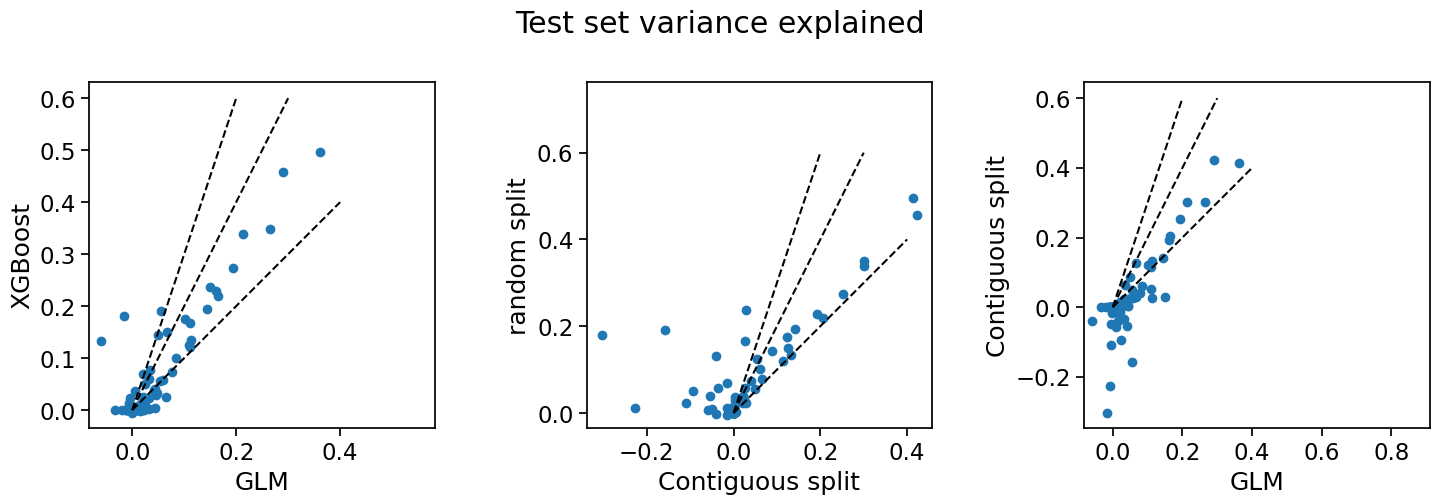

In [267]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_test_cont_split, xgb_ve_test_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Test set variance explained')
fig.tight_layout()



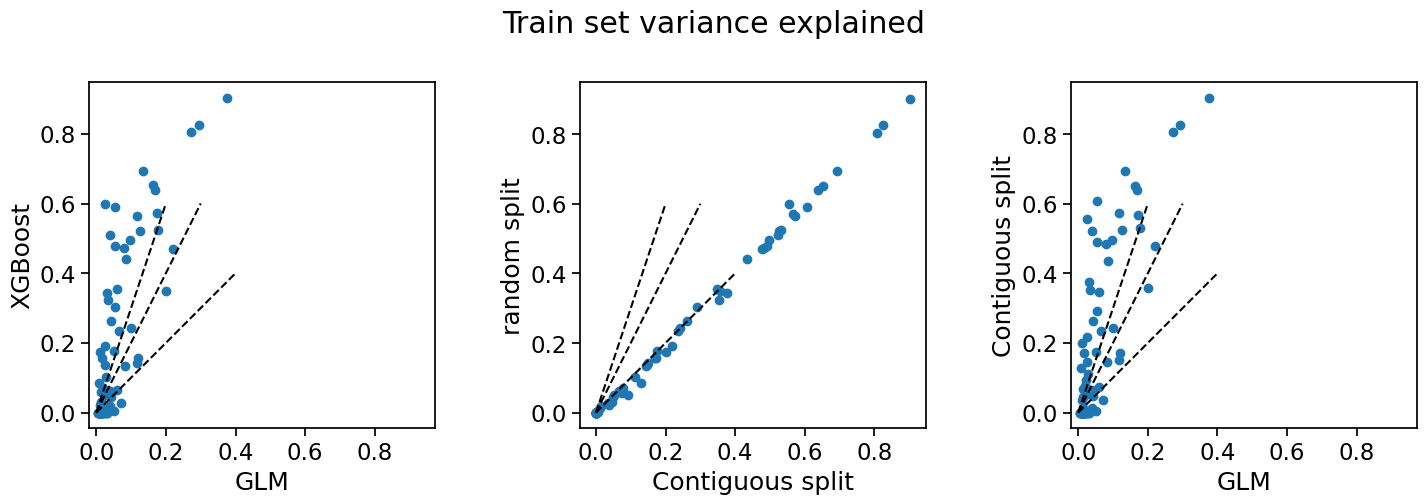

In [268]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_train_cont_split, xgb_ve_train_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Train set variance explained')
fig.tight_layout()


## Random split is better for model performance

Text(0.5, 0.98, 'Model performance (Exp 879331157)')

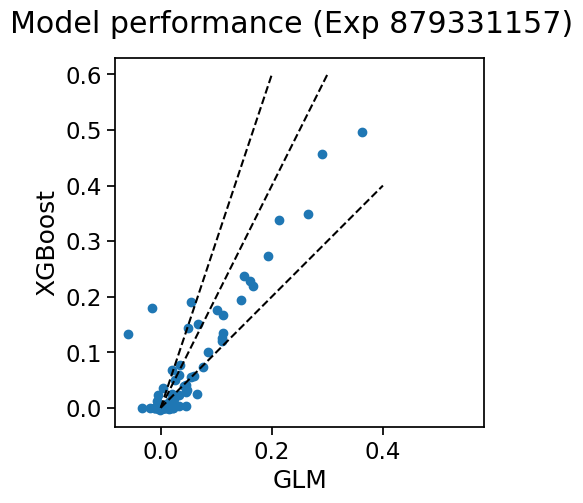

In [282]:
fig, ax = plt.subplots()
ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.plot([0, 0.3], [0, 0.6], 'k--')
ax.plot([0, 0.2], [0, 0.6], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')
fig.suptitle(f'Model performance (Exp {oeid})')

Text(0.5, 1.0, 'Exp 879331157 cross validation')

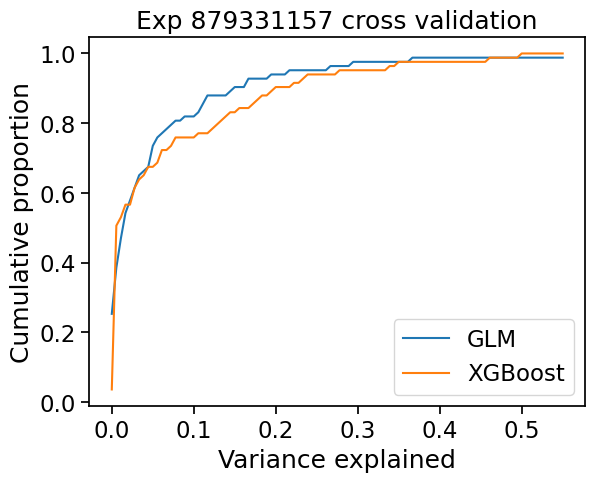

In [280]:
# Cumulative distribution of model performance
bins = [-1, *list(np.linspace(0, 0.55, 100))]
fig, ax = plt.subplots()
cumhist_glm = (np.histogram(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1), bins=bins)[0]/num_cells).cumsum()
cumhist_xgb = (np.histogram(xgb_ve_test_rand_split, bins=bins)[0]/num_cells).cumsum()
ax.plot(bins[1:], cumhist_glm, label='GLM')
ax.plot(bins[1:], cumhist_xgb, label='XGBoost')
ax.legend()
ax.set_xlabel('Variance explained')
ax.set_ylabel('Cumulative proportion')
ax.set_title(f'Exp {oeid} cross validation')

## Look at some example traces where XGBoost increased model fit

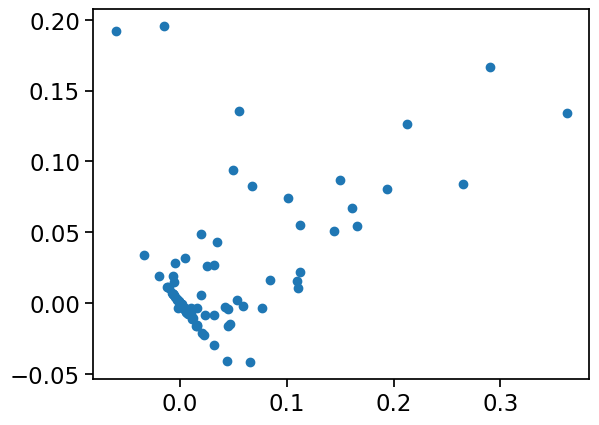

In [285]:
glm_fit = np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)
xgb_fit = xgb_ve_test_rand_split

fit_diff = xgb_fit - glm_fit
fig, ax = plt.subplots()
ax.scatter(glm_fit, fit_diff)

In [303]:
diff_ind_sort = np.argsort(-fit_diff)


In [393]:
alex_pred = np.zeros(fit['fit_trace_arr'].shape)
for si in range(num_splits):
    temp_pred = design.get_X().values @ fit['dropouts']['Full']['cv_weights'][:,:,si]
    test_ind = fit['splits'][si]
    alex_pred[test_ind, :] = temp_pred[test_ind]
    


In [306]:
xgb_pred_cell

array([1.52647044e-05, 1.11081008e-05, 1.42509207e-05, ...,
       1.44329333e-05, 1.43454581e-05, 1.44329333e-05])

In [308]:
glm_pred_cell

array([ 2.21701230e-05, -3.15219340e-06,  8.57625142e-06, ...,
        1.92120096e-04,  1.49369648e-04,  1.13042684e-04])

(88000.0, 90000.0)

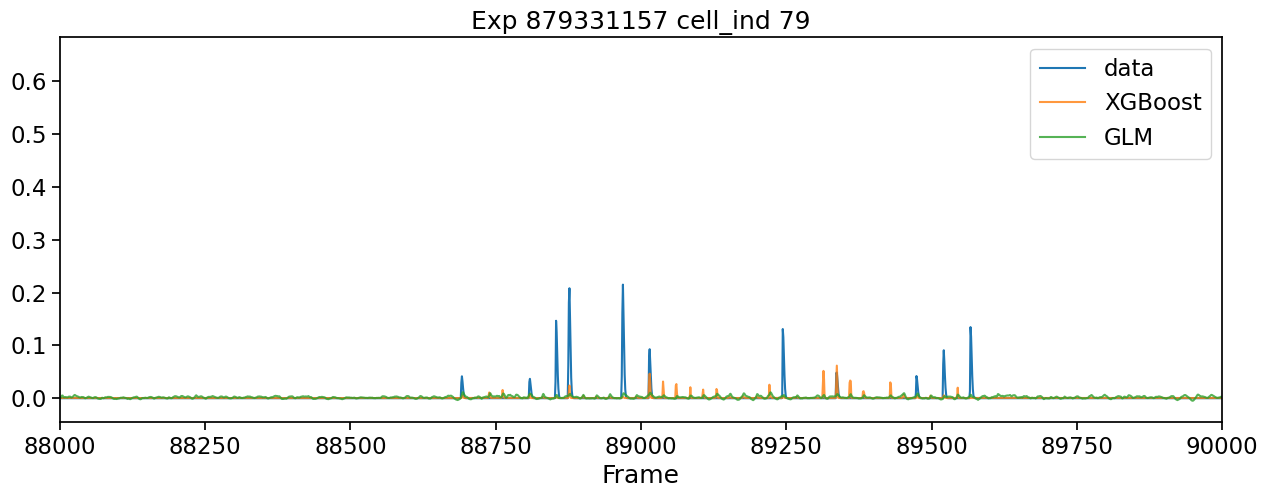

In [396]:
# ci = diff_ind_sort[5]
ci = 79
alpha = 0.8
results_fn = results_dir / f'oeid_{oeid}_cellind_{ci:03d}_xgb.npy'
results = np.load(results_fn, allow_pickle=True).item()
xgb_pred_cell = results['xgb_pred_rand_split']
glm_pred_cell = alex_pred[:,ci]
y = fit['fit_trace_arr'][:,ci].values
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y, label='data')
ax.plot(xgb_pred_cell, label='XGBoost', alpha=alpha)
ax.plot(glm_pred_cell, label='GLM', alpha=alpha)
ax.legend()
ax.set_title(f'Exp {oeid} cell_ind {ci}')
ax.set_xlabel('Frame')
start_frame = 88000
dur = 2000
ax.set_xlim(start_frame, start_frame+dur)

Text(0, 0.5, 'XGBoost')

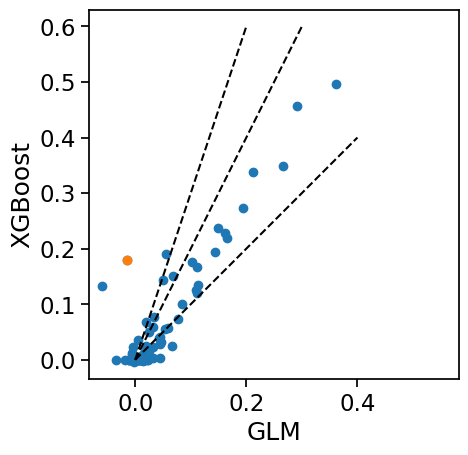

In [360]:
fig, ax = plt.subplots()
ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split)
ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)[ci],
                xgb_ve_test_rand_split[ci])
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.plot([0, 0.3], [0, 0.6], 'k--')
ax.plot([0, 0.2], [0, 0.6], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')
# fig.suptitle(f'Model performance (Exp {oeid})')

## Try running the other exp using the same hyperparameters

In [ ]:
oeid = oeids[1]
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)
num_cells = fit['fit_trace_arr'].shape[1]

In [404]:
results_dir = Path(r'D:\XGBoost\run\231130_v01')
cell_inds = [int(fn.split('_')[-2]) for fn in glob.glob(str(results_dir / f'oeid_{oeid}_cellind_*_xgb.npy'))]
assert(len(cell_inds) == (np.max(cell_inds)+1))
assert num_cells == len(cell_inds)
xgb_ve_train_rand_split = np.zeros(num_cells)
xgb_ve_test_rand_split = np.zeros(num_cells)
xgb_ve_train_cont_split = np.zeros(num_cells)
xgb_ve_test_cont_split = np.zeros(num_cells)
for ci in range(num_cells):
    results_fn = results_dir / f'oeid_{oeid}_cellind_{ci:03d}_xgb.npy'
    results = np.load(results_fn, allow_pickle=True).item()
    xgb_ve_train_rand_split[ci] = np.mean(results['xgb_ve_train_rand_split'])
    xgb_ve_test_rand_split[ci] = np.mean(results['xgb_ve_test_rand_split'])
    xgb_ve_train_cont_split[ci] = np.mean(results['xgb_ve_train_alex_split'])
    xgb_ve_test_cont_split[ci] = np.mean(results['xgb_ve_test_alex_split'])

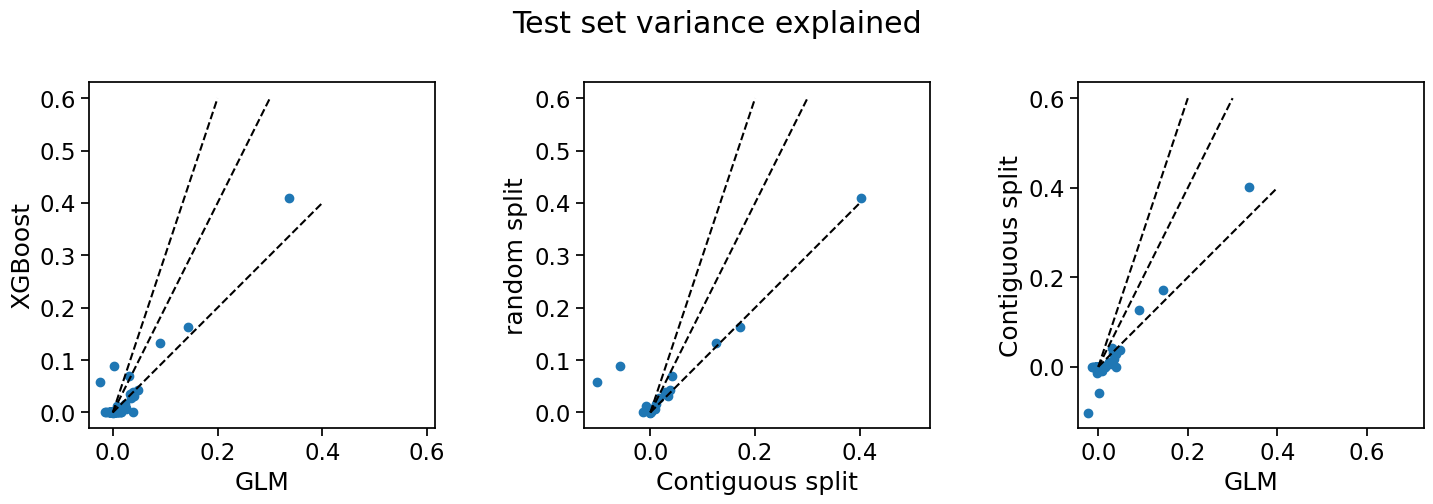

In [405]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_test_cont_split, xgb_ve_test_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Test set variance explained')
fig.tight_layout()



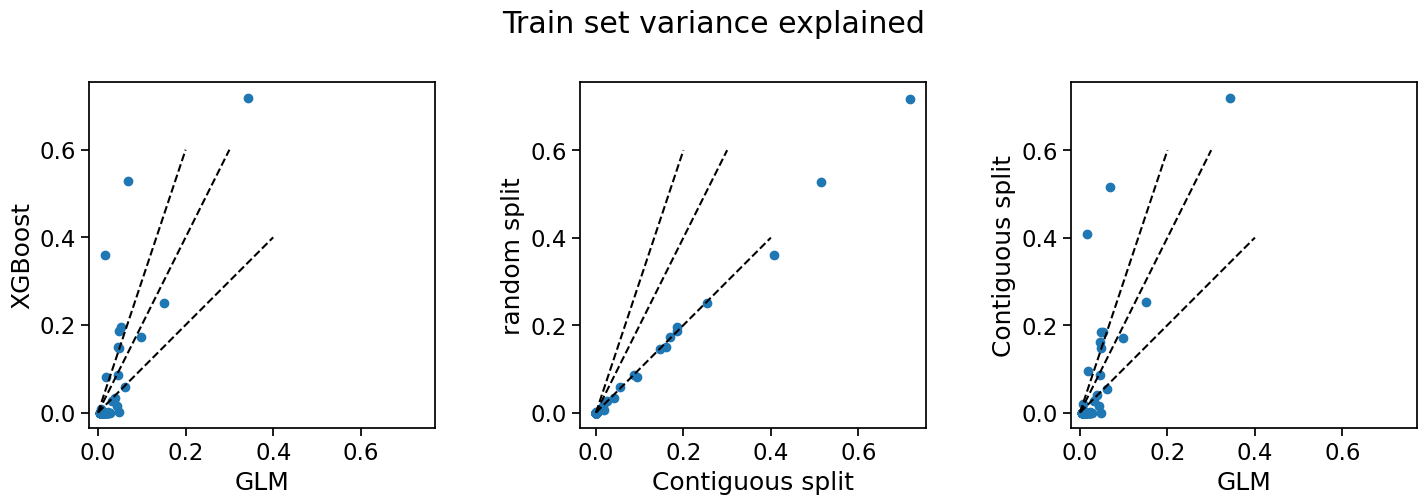

In [406]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_train_cont_split, xgb_ve_train_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Train set variance explained')
fig.tight_layout()


Text(0.5, 0.98, 'Model performance (Exp 1050725735)')

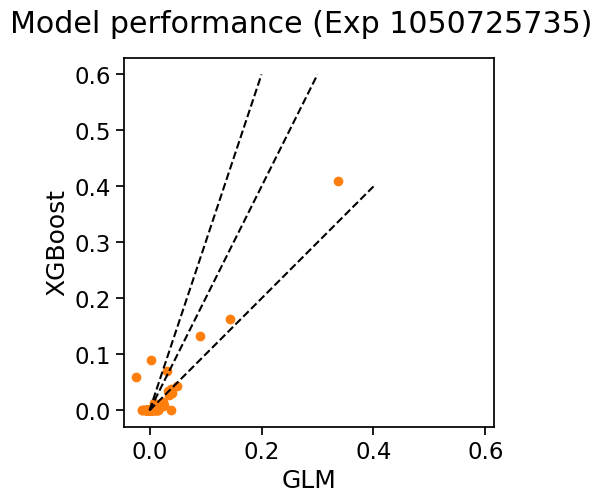

In [407]:
fig, ax = plt.subplots()
ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split, color='C1')
# ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)[ci],
#                 xgb_ve_test_rand_split[ci])
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.plot([0, 0.3], [0, 0.6], 'k--')
ax.plot([0, 0.2], [0, 0.6], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')
fig.suptitle(f'Model performance (Exp {oeid})')

In [397]:

results_dir = Path(r'D:\XGBoost\run\231201_v01')
cell_inds = [int(fn.split('_')[-2]) for fn in glob.glob(str(results_dir / f'oeid_{oeid}_cellind_*_xgb.npy'))]
assert(len(cell_inds) == (np.max(cell_inds)+1))
assert num_cells == len(cell_inds)
xgb_ve_train_rand_split = np.zeros(num_cells)
xgb_ve_test_rand_split = np.zeros(num_cells)
xgb_ve_train_cont_split = np.zeros(num_cells)
xgb_ve_test_cont_split = np.zeros(num_cells)
for ci in range(num_cells):
    results_fn = results_dir / f'oeid_{oeid}_cellind_{ci:03d}_xgb.npy'
    results = np.load(results_fn, allow_pickle=True).item()
    xgb_ve_train_rand_split[ci] = np.mean(results['xgb_ve_train_rand_split'])
    xgb_ve_test_rand_split[ci] = np.mean(results['xgb_ve_test_rand_split'])
    xgb_ve_train_cont_split[ci] = np.mean(results['xgb_ve_train_alex_split'])
    xgb_ve_test_cont_split[ci] = np.mean(results['xgb_ve_test_alex_split'])


loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Ind

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
Checked weight/kernel lengths against timesteps per stimulus


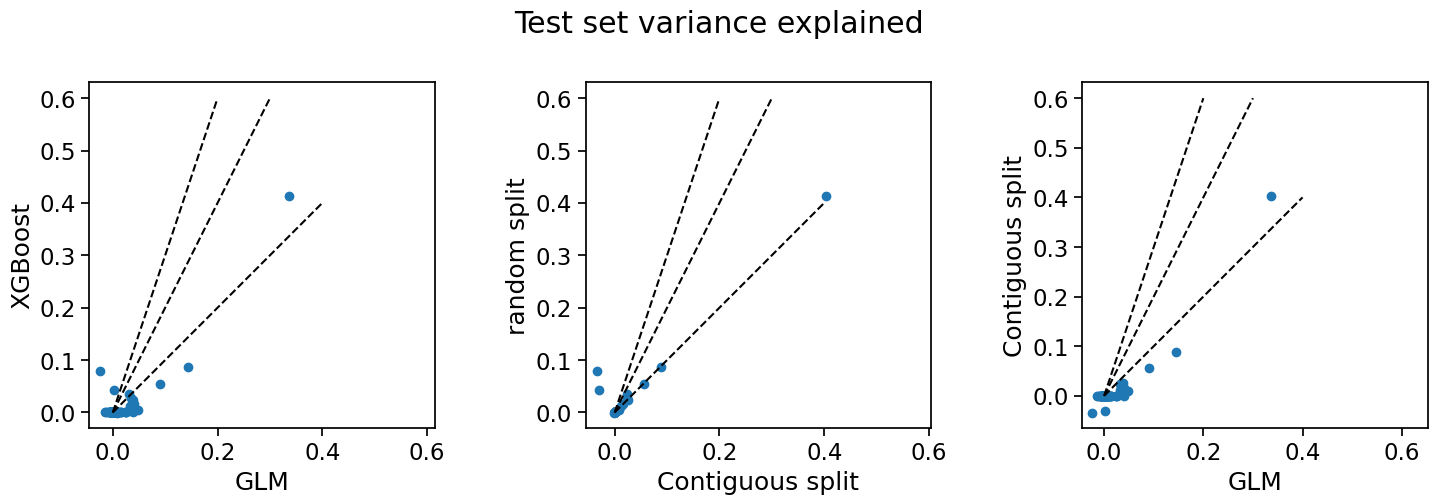

In [398]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_test_cont_split, xgb_ve_test_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Test set variance explained')
fig.tight_layout()



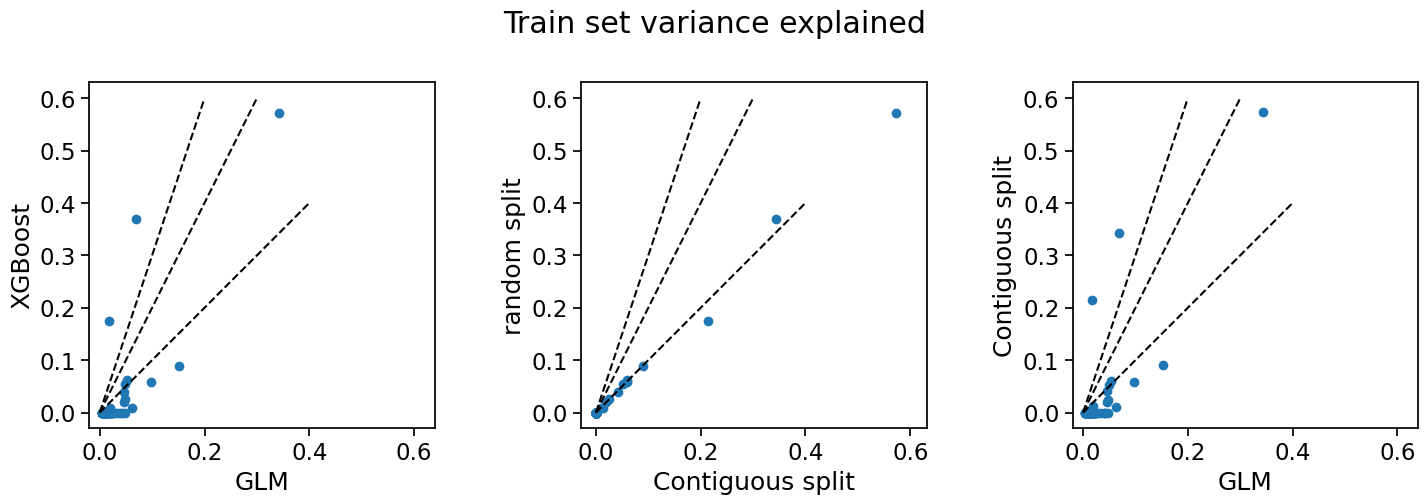

In [399]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_rand_split)
ax[0].plot([0, 0.4], [0, 0.4], 'k--')
ax[0].plot([0, 0.3], [0, 0.6], 'k--')
ax[0].plot([0, 0.2], [0, 0.6], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('GLM')
ax[0].set_ylabel('XGBoost')
ax[1].scatter(xgb_ve_train_cont_split, xgb_ve_train_rand_split)
ax[1].plot([0, 0.4], [0, 0.4], 'k--')
ax[1].plot([0, 0.3], [0, 0.6], 'k--')
ax[1].plot([0, 0.2], [0, 0.6], 'k--')
ax[1].axis('square')
ax[1].set_xlabel('Contiguous split')
ax[1].set_ylabel('random split')
ax[2].scatter(np.mean(fit['dropouts']['Full']['cv_var_train'], axis=1),
              xgb_ve_train_cont_split)
ax[2].plot([0, 0.4], [0, 0.4], 'k--')
ax[2].plot([0, 0.3], [0, 0.6], 'k--')
ax[2].plot([0, 0.2], [0, 0.6], 'k--')
ax[2].axis('square')
ax[2].set_xlabel('GLM')
ax[2].set_ylabel('Contiguous split')
fig.suptitle('Train set variance explained')
fig.tight_layout()


Text(0.5, 0.98, 'Model performance (Exp 1050725735)')

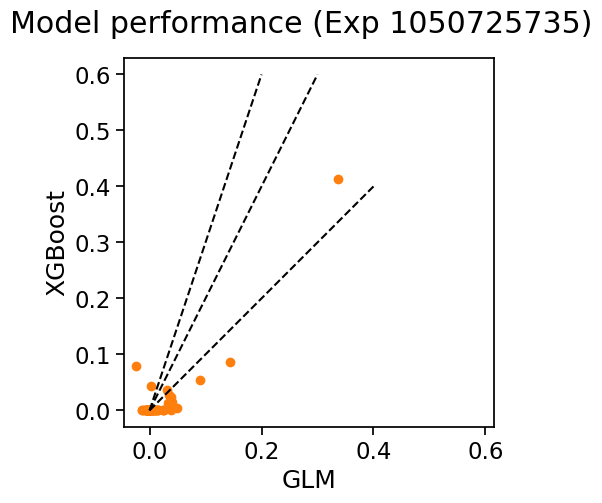

In [403]:
fig, ax = plt.subplots()
ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1),
              xgb_ve_test_rand_split, color='C1')
# ax.scatter(np.mean(fit['dropouts']['Full']['cv_var_test'], axis=1)[ci],
#                 xgb_ve_test_rand_split[ci])
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.plot([0, 0.3], [0, 0.6], 'k--')
ax.plot([0, 0.2], [0, 0.6], 'k--')
ax.axis('square')
ax.set_xlabel('GLM')
ax.set_ylabel('XGBoost')
fig.suptitle(f'Model performance (Exp {oeid})')

## Maybe, hyperparameters cannot be generalized across sessions
- Maybe also across cell
- Or maybe, this session was really hard to fit.
- Maybe activity rate could be the most deciding factor.
- Try finding the best hyperparameters for this experiment.
    - If it improves the performance, then look at the effect of activity rate.

# Test coding score
- Refitting by dropping parameters is costly, so apply shuffling each parameter (shuffle columns of same kernel the same way)

In [385]:
alex_run_param['kernels'].keys()

dict_keys(['intercept', 'hits', 'misses', 'omissions', 'running', 'pupil', 'licks', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7'])

In [388]:
X = design.get_X()[:,1:]
X

<xarray.DataArray (timestamps: 110377, weights: 603)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * weights     (weights) <U12 'hits_0' 'hits_1' ... 'image7_21' 'image7_22'
  * timestamps  (timestamps) float64 306.3 306.3 306.4 ... 3.908e+03 3.908e+03

In [392]:
X.weights.values

array(['hits_0', 'hits_1', 'hits_2', 'hits_3', 'hits_4', 'hits_5',
       'hits_6', 'hits_7', 'hits_8', 'hits_9', 'hits_10', 'hits_11',
       'hits_12', 'hits_13', 'hits_14', 'hits_15', 'hits_16', 'hits_17',
       'hits_18', 'hits_19', 'hits_20', 'hits_21', 'hits_22', 'hits_23',
       'hits_24', 'hits_25', 'hits_26', 'hits_27', 'hits_28', 'hits_29',
       'hits_30', 'hits_31', 'hits_32', 'hits_33', 'hits_34', 'hits_35',
       'hits_36', 'hits_37', 'hits_38', 'hits_39', 'hits_40', 'hits_41',
       'hits_42', 'hits_43', 'hits_44', 'hits_45', 'hits_46', 'hits_47',
       'hits_48', 'hits_49', 'hits_50', 'hits_51', 'hits_52', 'hits_53',
       'hits_54', 'hits_55', 'hits_56', 'hits_57', 'hits_58', 'hits_59',
       'hits_60', 'hits_61', 'hits_62', 'hits_63', 'hits_64', 'hits_65',
       'hits_66', 'hits_67', 'hits_68', 'hits_69', 'misses_0', 'misses_1',
       'misses_2', 'misses_3', 'misses_4', 'misses_5', 'misses_6',
       'misses_7', 'misses_8', 'misses_9', 'misses_10', 'misses_1

### Testing visual_behavior db connection
- Somehow visual_behavior_data mongo db cannot be connected

In [80]:
import yaml
db_info_filepath = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/mongo_db_info.yml'
with open(db_info_filepath, 'r') as stream:
    db_info = yaml.safe_load(stream)


In [81]:
db_info

{'mouseseeks': {'ip': '10.128.105.108', 'port': 27017},
 'visual_behavior_data': {'ip': 'behavioral-dynamics.corp.alleninstitute.org',
  'port': 27017},
 'visual_behavior_data_orig': {'ip': 'visb-lambda.corp.alleninstitute.org',
  'port': 27017}}

In [82]:
from pymongo import MongoClient
ip = db_info['visual_behavior_data']['ip']
port = db_info['visual_behavior_data']['port']
client = MongoClient('mongodb://{}:{}'.format(ip, port))

In [92]:
client

MongoClient(host=['behavioral-dynamics.corp.alleninstitute.org:27017'], document_class=dict, tz_aware=False, connect=True)

In [93]:
client.list_database_names()

ServerSelectionTimeoutError: behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655ef0bbf3b79ce30210bbae, topology_type: Unknown, servers: [<ServerDescription ('behavioral-dynamics.corp.alleninstitute.org', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [91]:
client.list_database_names()

ServerSelectionTimeoutError: behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655ef0bbf3b79ce30210bbae, topology_type: Unknown, servers: [<ServerDescription ('behavioral-dynamics.corp.alleninstitute.org', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [90]:
[db for db in client.list_database_names() if db != 'admin']

ServerSelectionTimeoutError: behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655ef0bbf3b79ce30210bbae, topology_type: Unknown, servers: [<ServerDescription ('behavioral-dynamics.corp.alleninstitute.org', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('behavioral-dynamics.corp.alleninstitute.org:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>